In [1]:
# Core
import re, os, sys, string, random, functools
import pandas as pd
from pathlib import Path
import numpy as np
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
# Stats and machine learning
from sklearn import preprocessing, impute
from sklearn.experimental import enable_iterative_imputer
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scikit_posthocs as skph
import xgboost as xgb
import imblearn as imb
import statsmodels.api as sm
# Reduce warnings
import warnings
warnings.filterwarnings('once')

In [2]:
def getIndexMax(a):
    return max(range(len(a)), key=a.__getitem__)

In [3]:
def flatten(l):
    return [item for sublist in l for item in sublist]

First I'll load the data the same way as for the classic stats.

In [4]:
morpho = pd.read_csv("../Data/All-morphological-data.csv")
morpho["MajorLineage"] = morpho["MajorLineage"].replace("Clusia","Clusiaceae")

morpho = morpho.drop(["fSLAmean (mm^2/mg)", "fSLAse (mm^2/mg)"], axis=1).reset_index(drop=True)
dataCols = [c for c in morpho.columns if "mean" in c]

logMorpho = np.log10(morpho[dataCols])
for c in set(morpho.columns).difference(set(dataCols)):
    logMorpho[c] = morpho[c]

logMorpho.head()

,MAmean (um^2),LTmean (um),IASmean (%),LDMCmean (g/g),dSLAmean (mm^2/mg),CAMphenoCat,Pathway,MajorLineage,Taxon,Tissue,CAMpheno,Reference,Genus,color,Species,dSLAse (mm^2/mg),LDMCse (g/g)
0,NaN,NaN,NaN,NaN,0.717604,0,C3,Acanthaceae,Acanthopsis disperma,leaf,non-CAM,"Cornwell WK, Wright I, Turner J, Maire V, Barb...",Acanthopsis,xkcd:light eggplant,disperma,NaN,NaN
1,NaN,NaN,NaN,NaN,0.324247,0,C3,Acanthaceae,Acanthus ilicifolius,leaf,non-CAM,eHALOPH - Halophytes Database (version 3.11) T...,Acanthus,xkcd:light eggplant,ilicifolius,NaN,NaN
2,NaN,2.568202,NaN,NaN,0.817565,0,C3,Acanthaceae,Avicennia alba,leaf,non-CAM,eHALOPH - Halophytes Database (version 3.11) T...,Avicennia,xkcd:light eggplant,alba,0.000000e+00,NaN
3,NaN,NaN,NaN,NaN,0.933508,0,C3,Acanthaceae,Avicennia germinans,leaf,non-CAM,eHALOPH - Halophytes Database (version 3.11) T...,Avicennia,xkcd:light eggplant,germinans,3.153483e+00,NaN
4,NaN,NaN,NaN,NaN,0.683047,0,C3,Acanthaceae,Avicennia lanata,leaf,non-CAM,eHALOPH - Halophytes Database (version 3.11) T...,Avicennia,xkcd:light eggplant,lanata,4.905126e-15,NaN


Let's see what the data look like. For the purposes of these analyses I'll divide the species between "non-CAM", "non-primary CAM", and "primary CAM".

In [5]:
nonCAMcolor = "xkcd:light eggplant"
nonpCAMcolor = "xkcd:apricot"
pCAMcolor = "xkcd:lichen"
cmap = {"C3":nonCAMcolor, "C4":nonCAMcolor, "CAM":pCAMcolor, "C3-C4+CAM":nonpCAMcolor, "C4+CAM":nonpCAMcolor, "C3+CAM":nonpCAMcolor}
camColorDict = {"non-CAM":nonCAMcolor, "mCAM":nonpCAMcolor, "pCAM":pCAMcolor}

## Machine learning based classification
In this section I'll try to classify plant photosynthetic systems based on the morphological data above.

### XGBoost

In [6]:
toCategorical = {"non-CAM":0, "mCAM":1, "pCAM":2}
morpho["label"] = [toCategorical[p] for p in morpho["CAMpheno"]]
logMorpho["label"] = [toCategorical[p] for p in logMorpho["CAMpheno"]]

In [7]:
X_train, X_test = train_test_split(logMorpho, test_size=0.2, random_state=9999)
X_train = X_train.sort_values("Taxon").reset_index(drop=True)
X_test = X_test.sort_values("Taxon").reset_index(drop=True)
dtrain = xgb.DMatrix(data=X_train[dataCols], label=X_train["label"], missing=np.NaN)
dtest = xgb.DMatrix(data=X_test[dataCols], label=X_test["label"], missing=np.NaN)

#### Classifier parameters

In [8]:
prmsSmaxMerr = {'tree_method':'exact','objective': 'multi:softmax','num_class':3,'nthread':-1,'subsample':0.75,'eval_metric':'merror',}
prmsSprobMerr = {'tree_method':'exact','objective': 'multi:softprob','num_class':3,'nthread':-1,'subsample':0.75,'eval_metric':'merror'} 
prmsSprobAUC = {'tree_method':'exact','objective': 'multi:softprob','num_class':3,'nthread':-1,'subsample':0.75,'eval_metric':'auc'} # objective should be multi:softprob for auc
prmsSmaxLogL = {'tree_method':'exact','objective': 'multi:softmax','num_class':3,'nthread':-1,'subsample':0.75,'eval_metric':'mlogloss'}
prmsSprobLogL = {'tree_method':'exact','objective': 'multi:softprob','num_class':3,'nthread':-1,'subsample':0.75,'eval_metric':'mlogloss'}
prmsDartSmaxMerr = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform','normalize_type':'tree','objective': 
                    'multi:softmax','num_class':3,'nthread':-1,'subsample':0.75,'eval_metric':'merror'} # objective should be multi:softprob for auc
prmsDartSprobMerr = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform','normalize_type':'tree','objective': 
                     'multi:softprob','num_class':3,'nthread':-1, 'subsample':0.75,'eval_metric':'merror'} # objective should be multi:softprob for auc
prmsDartSprobAUC = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform','normalize_type':'tree','objective': 
                    'multi:softprob','num_class':3,'nthread':-1,'subsample':0.75,'eval_metric':'auc'} # objective should be multi:softprob for auc
prmsDartSmaxLogL = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform','normalize_type':'tree','objective': 
                    'multi:softmax','num_class':3,'nthread':-1,'subsample':0.75,'eval_metric':'mlogloss'}
prmsDartSprobLogL = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform','normalize_type':'tree','objective': 
                     'multi:softprob','num_class':3,'nthread':-1,'subsample':0.75,'eval_metric':'mlogloss'}
evalList = [(dtrain, 'train'), (dtest, 'eval')]

#### Training

In [9]:
num_round = 10
bstSmaxMerr = xgb.train(prmsSmaxMerr, dtrain, num_round, evalList, verbose_eval=10)
bstSprobMerr = xgb.train(prmsSprobMerr, dtrain, num_round, evalList, verbose_eval=10)
bstSprobAUC = xgb.train(prmsSprobAUC, dtrain, num_round, evalList, verbose_eval=10)
bstSmaxLogL = xgb.train(prmsSmaxLogL, dtrain, num_round, evalList, verbose_eval=10)
bstSprobLogL = xgb.train(prmsSprobLogL, dtrain, num_round, evalList, verbose_eval=10)
bstDartSmaxMerr = xgb.train(prmsDartSmaxMerr, dtrain, num_round, evalList, verbose_eval=10)
bstDartSprobMerr = xgb.train(prmsDartSprobMerr, dtrain, num_round, evalList, verbose_eval=10)
bstDartSprobAUC = xgb.train(prmsDartSprobAUC, dtrain, num_round, evalList, verbose_eval=10)
bstDartSmaxLogL = xgb.train(prmsDartSmaxLogL, dtrain, num_round, evalList, verbose_eval=10)
bstDartSprobLogL = xgb.train(prmsDartSprobLogL, dtrain, num_round, evalList, verbose_eval=10)

[0]	train-merror:0.03286	eval-merror:0.05831
[9]	train-merror:0.02219	eval-merror:0.05396
[0]	train-merror:0.03286	eval-merror:0.05831
[9]	train-merror:0.02219	eval-merror:0.05396
[0]	train-auc:0.96785	eval-auc:0.94171
[9]	train-auc:0.99288	eval-auc:0.95538
[0]	train-mlogloss:0.73289	eval-mlogloss:0.74737
[9]	train-mlogloss:0.09967	eval-mlogloss:0.16418
[0]	train-mlogloss:0.73289	eval-mlogloss:0.74737
[9]	train-mlogloss:0.09967	eval-mlogloss:0.16418
[0]	train-merror:0.03003	eval-merror:0.05483
[9]	train-merror:0.02393	eval-merror:0.05396
[0]	train-merror:0.03003	eval-merror:0.05483
[9]	train-merror:0.02393	eval-merror:0.05396
[0]	train-auc:0.96849	eval-auc:0.94016
[9]	train-auc:0.99093	eval-auc:0.96363
[0]	train-mlogloss:0.73239	eval-mlogloss:0.74729
[9]	train-mlogloss:0.14663	eval-mlogloss:0.20213
[0]	train-mlogloss:0.73239	eval-mlogloss:0.74729
[9]	train-mlogloss:0.14663	eval-mlogloss:0.20213


#### Prediction

In [10]:
ypredSmaxMerr = bstSmaxMerr.predict(dtest)
ypredSprobMerr = bstSprobMerr.predict(dtest)
ypredSprobAUC  = bstSprobAUC.predict(dtest)
ypredSmaxLogL = bstSmaxLogL.predict(dtest)
ypredSprobLogL = bstSprobLogL.predict(dtest)
ypredDartSmaxMerr = bstDartSmaxMerr.predict(dtest)
ypredDartSprobMerr = bstDartSprobMerr.predict(dtest)
ypredDartSprobAUC  = bstDartSprobAUC.predict(dtest)
ypredDartSmaxLogL = bstDartSmaxLogL.predict(dtest)
ypredDartSprobLogL = bstDartSprobLogL.predict(dtest)
X_test["ypredSmaxMerr"] = [int(i) for i in ypredSmaxMerr]
X_test["ypredSprobMerr"] = [int(getIndexMax(a)) for a in ypredSprobMerr]
X_test["ypredSprobAUC"] = [int(getIndexMax(a)) for a in ypredSprobAUC]
X_test["ypredDartSmaxMerr"] = [int(i) for i in ypredDartSmaxMerr]
X_test["ypredDartSprobMerr"] = [int(getIndexMax(a)) for a in ypredDartSprobMerr]
X_test["ypredDartSprobAUC"] = [int(getIndexMax(a)) for a in ypredDartSprobAUC]
X_test["ypredSmaxLogL"] = [int(i) for i in ypredSmaxLogL]
X_test["ypredSprobLogL"] = [int(getIndexMax(a)) for a in ypredSprobLogL]
X_test["ypredDartSmaxLogL"] = [int(i) for i in ypredDartSmaxLogL]
X_test["ypredDartSprobLogL"] = [int(getIndexMax(a)) for a in ypredDartSprobLogL]
basePredCols = sorted(["ypredSmaxMerr", "ypredSprobMerr", "ypredSprobAUC","ypredDartSmaxMerr","ypredDartSprobMerr",
                  "ypredDartSprobAUC","ypredSmaxLogL","ypredSprobLogL","ypredDartSmaxLogL","ypredDartSprobLogL"])

#### Classification reports

In [11]:
print(metrics.classification_report(y_true=X_test["label"], y_pred=X_test["ypredSprobMerr"],digits=3))

              precision    recall  f1-score   support

           0      0.966     0.988     0.977      1048
           1      0.692     0.340     0.456        53
           2      0.654     0.708     0.680        48

    accuracy                          0.946      1149
   macro avg      0.771     0.679     0.704      1149
weighted avg      0.941     0.946     0.940      1149



In [12]:
print(metrics.classification_report(y_true=X_test["label"], y_pred=X_test["ypredDartSprobMerr"],digits=3))

              precision    recall  f1-score   support

           0      0.964     0.989     0.976      1048
           1      0.654     0.321     0.430        53
           2      0.708     0.708     0.708        48

    accuracy                          0.946      1149
   macro avg      0.775     0.673     0.705      1149
weighted avg      0.939     0.946     0.940      1149



#### Cross-validation accuracies

In [13]:
mErrorParams = [prmsSmaxMerr, prmsSprobMerr, prmsDartSmaxMerr, prmsDartSprobMerr]
aucParams = [prmsSprobAUC, prmsDartSprobAUC]
loglossParams = [prmsSmaxLogL, prmsSprobLogL, prmsDartSmaxLogL, prmsDartSprobLogL]

mErrorsMeans = []
mErrorsStds = []
aucMeans = []
aucStds = []
loglossMeans = []
loglossStds = []

for me in mErrorParams:
    foo = xgb.cv(params=me, dtrain=dtrain, nfold=10, seed=9999)
    mErrorsMeans.append(foo.iloc[-1][2])
    mErrorsStds.append(foo.iloc[-1][3])
for a in aucParams:
    foo = xgb.cv(params=a, dtrain=dtrain, nfold=10, seed=9999)
    aucMeans.append(foo.iloc[-1][2])
    aucStds.append(foo.iloc[-1][3])
for ll in loglossParams:
    foo = xgb.cv(params=ll, dtrain=dtrain, nfold=10, seed=9999)
    loglossMeans.append(foo.iloc[-1][2])
    loglossStds.append(foo.iloc[-1][3])

In [14]:
print(mErrorsMeans)
print(aucMeans)
print(loglossMeans)

[0.0404632, 0.0404632, 0.0408989, 0.0408989]
[0.9767336, 0.9705516999999999]
[0.1411099, 0.1411099, 0.1610525, 0.1610525]


In [15]:
basePrecision = []
baseRecall = []
baseF1 = []
for i in range(3):
    basePrecision.append(flatten([metrics.precision_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in basePredCols]))
    baseRecall.append(flatten([metrics.recall_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in basePredCols]))
    baseF1.append(flatten([metrics.f1_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in basePredCols]))

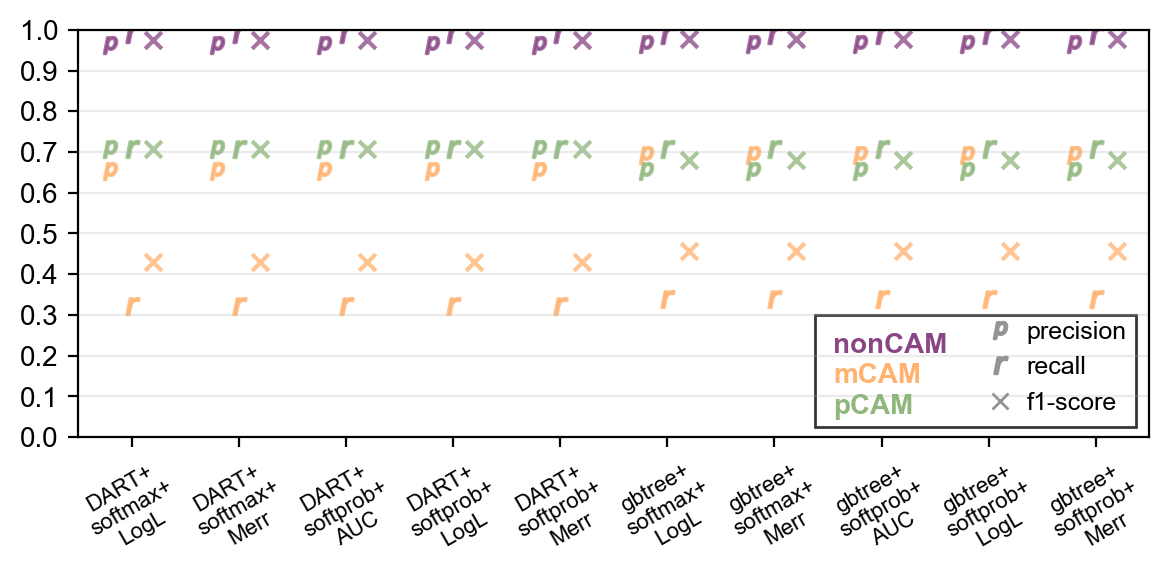

In [16]:
fig, ax = plt.subplots(nrows=1, figsize=(6,3))


for j,pheno in enumerate(["non-CAM","mCAM","pCAM"]):
    ax.scatter(x=[i-0.2 for i in range(len(basePredCols))], y=basePrecision[j], c=camColorDict[pheno], marker='$p$', alpha=0.75)
    ax.scatter(x=range(len(basePredCols)), y=baseRecall[j], c=camColorDict[pheno], marker='$r$', alpha=0.75)
    ax.scatter(x=[i+0.2 for i in range(len(basePredCols))], y=baseF1[j], c=camColorDict[pheno], marker="x", alpha=0.75)

ax.set_xticks(np.arange(0,len(basePredCols),1))
ax.set_xlim(-0.5,len(basePredCols)-0.5)
ax.set_xticklabels(['DART+\nsoftmax+\nLogL','DART+\nsoftmax+\nMerr','DART+\nsoftprob+\nAUC','DART+\nsoftprob+\nLogL','DART+\nsoftprob+\nMerr',
'gbtree+\nsoftmax+\nLogL','gbtree+\nsoftmax+\nMerr','gbtree+\nsoftprob+\nAUC','gbtree+\nsoftprob+\nLogL','gbtree+\nsoftprob+\nMerr',], size=8, rotation=30)
    
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid(axis='y', alpha=0.25)
ax.set_ylim(0,1)

ax.text(s="nonCAM", x=6.55, y=0.225, weight='bold', c=camColorDict['non-CAM'], verticalalignment='center')
ax.text(s="mCAM", x=6.55, y=0.15, weight='bold', c=camColorDict['mCAM'], verticalalignment='center')
ax.text(s="pCAM", x=6.55, y=0.075, weight='bold', c=camColorDict['pCAM'], verticalalignment='center')


precisionSquare = Line2D([0], [0], marker='$p$', color='xkcd:grey', label=r'precision',linestyle="none")
recallCircle = Line2D([0], [0], marker='$r$', color='xkcd:grey', label=r'recall',linestyle="none")
f1Triangle = Line2D([0], [0], marker='x', color='xkcd:grey',  label=r'f1-score',linestyle="none")
ax.legend(handles=[precisionSquare, recallCircle, f1Triangle], frameon=False, loc='lower right', fontsize=9, ncol=1, handletextpad=0.05)

rect = Rectangle(xy=[6.375, 0.025], height=0.275, width=3, edgecolor="xkcd:dark grey", facecolor='None')
ax.add_patch(rect)

plt.tight_layout()
# plt.savefig("../Figures/BaseClassificationMetrics.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

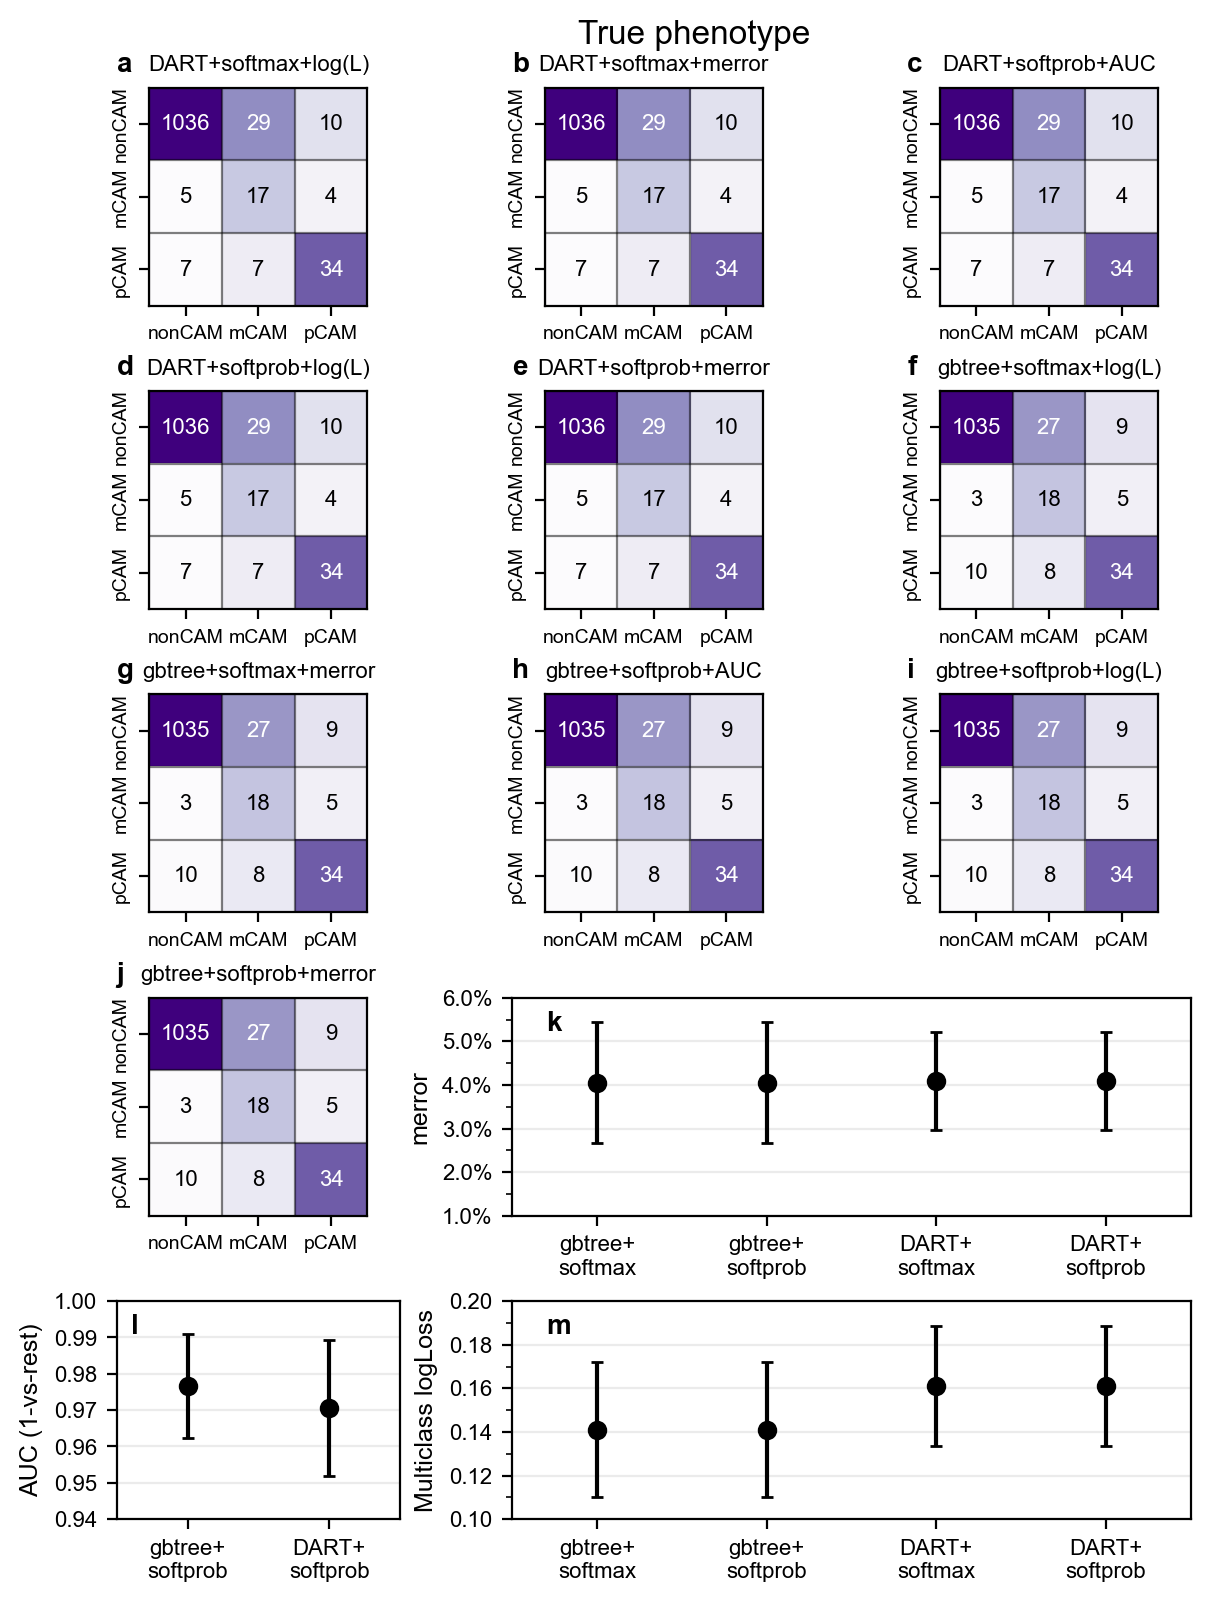

In [17]:
fig, ax = plt.subplot_mosaic('''
                             AABBCC
                             DDEEFF
                             GGHHII
                             JJKKKK
                             LLMMMM
                             ''', figsize=(6,8))

titles = ["DART+softmax+log(L)","DART+softmax+merror","DART+softprob+AUC","DART+softprob+log(L)","DART+softprob+merror",
          "gbtree+softmax+log(L)","gbtree+softmax+merror","gbtree+softprob+AUC","gbtree+softprob+log(L)","gbtree+softprob+merror",]


for i,c in enumerate(basePredCols):
    currAx =ax[string.ascii_uppercase[i]]
    cMat = metrics.confusion_matrix(X_test[c], X_test["label"])
    cMatNorm = metrics.confusion_matrix(X_test[c], X_test["label"],normalize='pred')
    currAx.imshow(cMatNorm,cmap="Purples")
    currAx.set_xticks(np.arange(-0.5,2.5,1), minor=True)
    currAx.set_yticks(np.arange(-0.5,2.5,1), minor=True)
    currAx.set_xticks([0,1,2])
    currAx.set_yticks([0,1,2])
    currAx.set_xticklabels(["nonCAM", "mCAM","pCAM",],size=7)
    currAx.set_yticklabels(["nonCAM", "mCAM","pCAM",],size=7, rotation=90, va="center")
    
    for x in range(len(cMat)):
        for y in range(len(cMat)):
            if cMatNorm[x,y] > 0.5: color="white"
            else: color="black"
            text = currAx.text(y,x, cMat[x,y], ha="center", va="center", color=color, size=8)
    currAx.set_title(titles[i],size=8)
    currAx.text(s=string.ascii_lowercase[i], x=-0.15, y=1.075, size=10, transform = currAx.transAxes, weight="bold")
    
    currAx.tick_params(which="minor", size=0)
    currAx.grid(which="minor", color="black", alpha=0.5)

ax['K'].errorbar(x=range(4), y=mErrorsMeans, yerr=mErrorsStds, linestyle='none', marker="o", color="black", capsize=2)
ax['L'].errorbar(x=range(2), y=aucMeans, yerr=aucStds, linestyle='none', marker="o", color="black", capsize=2)
ax['M'].errorbar(x=range(4), y=loglossMeans, yerr=loglossStds, linestyle='none', marker="o", color="black", capsize=2)

ax['K'].set_xticks(range(4))
ax['L'].set_xticks(range(4))
ax['M'].set_xticks(range(4))

ax['K'].set_xlim(-0.5,3.5)
ax['L'].set_xlim(-0.5,1.5)
ax['M'].set_xlim(-0.5,3.5)

ax['K'].set_ylabel("merror", size=9)
ax['L'].set_ylabel("AUC (1-vs-rest)", size=9)
ax['M'].set_ylabel("Multiclass logLoss", size=9)

ax['K'].set_xticklabels(['gbtree+\nsoftmax', 'gbtree+\nsoftprob', 'DART+\nsoftmax', 'DART+\nsoftprob'], size=8)
ax['L'].set_xticklabels(['gbtree+\nsoftprob', 'DART+\nsoftprob', '', ''], size=8)
ax['M'].set_xticklabels(['gbtree+\nsoftmax', 'gbtree+\nsoftprob', 'DART+\nsoftmax', 'DART+\nsoftprob'], size=8)

ax['K'].set_yticks(np.arange(0.0, 0.07, 0.01))
ax['K'].set_yticks(np.arange(0.0, 0.07, 0.005), minor=True)
ax['K'].set_yticklabels(["{:1.1%}".format(t) for t in np.arange(0.0, 0.07, 0.01)], size=8)
ax['K'].set_ylim(0.01,0.06)
ax['L'].set_yticks(np.arange(0.9, 1.1, 0.01))
ax['L'].set_yticklabels(["{:0.2f}".format(t) for t in np.arange(0.9, 1.1, 0.01)], size=8)
ax['L'].set_ylim(0.94,1.0)
ax['M'].set_yticks(np.arange(0.1, 0.22, 0.02))
ax['M'].set_yticks(np.arange(0.1, 0.22, 0.01), minor=True)
ax['M'].set_yticklabels(["{:1.2f}".format(t) for t in np.arange(0.1, 0.22, 0.02)], size=8)
ax['M'].set_ylim(0.1,0.2)

for i in 'KLM':
    ax[i].text(s=str.lower(i), x=0.05, y=0.85, size=10, transform = ax[i].transAxes, weight="bold")
    ax[i].grid(alpha=0.25, axis="y")

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
plt.ylabel("Predicted phenotype", size=12, labelpad=-10)
plt.suptitle("True phenotype", size=12, x=0.575, y=0.985)
plt.axis('off')

plt.tight_layout(pad=0.5)
# plt.savefig("../Figures/BaseErrorMetrics.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

The error doesn't differ between gbtree and dart boosting methods, but dart does seem to perform slightly worse given the last two plots. AUC is just slightly less (definitely not significantly different), and the logloss is higher. It looks like we're calling a lot of mCAM things non-CAM with current models.

#### Feature importance

In [18]:
bstList = [bstDartSmaxLogL,bstDartSmaxMerr,bstDartSprobAUC,bstDartSprobLogL,bstDartSprobMerr,
       bstSmaxLogL,bstSmaxMerr,bstSprobAUC,bstSprobLogL,bstSprobMerr,]
keys = ['LTmean (um)','MAmean (um^2)','LDMCmean (g/g)','dSLAmean (mm^2/mg)','IASmean (%)']

basefScores = []

for b in bstList:
    basefScores.append([b.get_fscore()[k]/sum(b.get_fscore().values()) for k in keys])

basefScores = pd.DataFrame(basefScores, columns=keys)
models = ["DART+softmax+log(L)","DART+softmax+merror","DART+softprob+AUC","DART+softprob+log(L)","DART+softprob+merror",
          "gbtree+softmax+log(L)","gbtree+softmax+merror","gbtree+softprob+AUC","gbtree+softprob+log(L)","gbtree+softprob+merror",]
basefScores["Model"] = [m.split("+")[0] for m in models]
basefScores["Objective function"] = [m.split("+")[1] for m in models]
basefScores["Evaluation metric"] = [m.split("+")[2] for m in models]
basefScores = basefScores.rename({'LTmean (um)':"LT",'MAmean (um^2)':"MA",'LDMCmean (g/g)':"LDMC",'dSLAmean (mm^2/mg)':"SLA",'IASmean (%)':"IAS"},axis=1)
basefScores[["Model", "Objective function", "Evaluation metric","LT","MA","LDMC","SLA","IAS"]]#.to_csv("../Results/BaseModelFscores.csv",index=False)

,Model,Objective function,Evaluation metric,LT,MA,LDMC,SLA,IAS
0,DART,softmax,log(L),0.336364,0.277922,0.138961,0.106494,0.140260
1,DART,softmax,merror,0.336364,0.277922,0.138961,0.106494,0.140260
2,DART,softprob,AUC,0.336364,0.277922,0.138961,0.106494,0.140260
3,DART,softprob,log(L),0.336364,0.277922,0.138961,0.106494,0.140260
4,DART,softprob,merror,0.336364,0.277922,0.138961,0.106494,0.140260
5,gbtree,softmax,log(L),0.322377,0.260430,0.149178,0.123894,0.144121
6,gbtree,softmax,merror,0.322377,0.260430,0.149178,0.123894,0.144121
7,gbtree,softprob,AUC,0.322377,0.260430,0.149178,0.123894,0.144121
8,gbtree,softprob,log(L),0.322377,0.260430,0.149178,0.123894,0.144121
9,gbtree,softprob,merror,0.322377,0.260430,0.149178,0.123894,0.144121


Feature importance is identical within boosters.

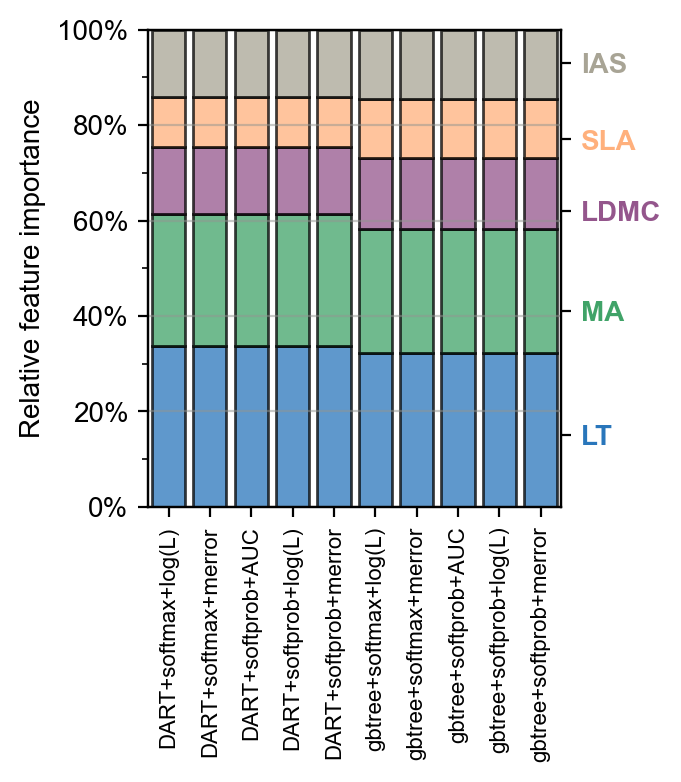

In [19]:
fig, ax = plt.subplots(figsize=(3.5,4))

barColors = ["xkcd:bluish", "xkcd:greenish","xkcd:purplish","xkcd:peach","xkcd:greyish"]
keys = ['LT', 'MA', 'LDMC', 'SLA', 'IAS']
for i,k in enumerate(keys):
    if i==0:
        ax.bar(x=range(len(basefScores)), height=basefScores[k], alpha=0.75, color=barColors[i], edgecolor="black")
    else:
        ax.bar(x=range(len(basefScores)), height=basefScores[k], bottom=basefScores[keys[:i]].sum(axis=1), alpha=0.75, color=barColors[i], edgecolor="black")
  
ax.set_xticks(range(len(basefScores)))
ax.set_xticklabels(["DART+softmax+log(L)","DART+softmax+merror","DART+softprob+AUC","DART+softprob+log(L)","DART+softprob+merror",
              "gbtree+softmax+log(L)","gbtree+softmax+merror","gbtree+softprob+AUC","gbtree+softprob+log(L)","gbtree+softprob+merror",], size=8, rotation=90)
ax.set_xlim(-0.5,9.5)
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.1,0.1), minor=True)
ax.set_yticklabels(["{:1.0%}".format(t) for t in ax.get_yticks()])
ax.set_ylim(0,1)
ax.set_ylabel("Relative feature importance", size=10)
ax.grid(color="xkcd:grey", alpha=0.5, axis="y")

ax2 = ax.twinx()
ax2.set_yticks([0.15,0.41,0.62,0.77,0.93])
ax2.set_yticklabels(["LT", "MA", "LDMC", "SLA", "IAS"], weight="bold")
for ticklabel, tickcolor in zip(ax2.get_yticklabels(), barColors):
    ticklabel.set_color(tickcolor)
    
plt.tight_layout()
# plt.savefig("../Figures/BaseFeatureImportanceBars.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

### Attemps to address bias
Our classes are substantially biased, with an order of magnitude more non-CAM than mCAM or pCAM samples. These methods attempt to help clasification with biased sampling

#### Changing `max_delta_step`

In [20]:
print("Missing data: {:%}".format((X_train[dataCols].isna().sum().sum() / (X_train[dataCols].shape[0]*X_train[dataCols].shape[1]))))

Missing data: 66.731941%


In [21]:
prmsMD0dart = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform',
           'normalize_type':'tree', 'objective': 'multi:softprob','num_class':3,'nthread':-1,
           'subsample':0.75, 'eval_metric':'merror', 'max_delta_step':0}
prmsMD1dart = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform',
           'normalize_type':'tree', 'objective': 'multi:softprob','num_class':3,'nthread':-1,
           'subsample':0.75, 'eval_metric':'merror', 'max_delta_step':1}
prmsMD2dart = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform',
           'normalize_type':'tree', 'objective': 'multi:softprob','num_class':3,'nthread':-1,
           'subsample':0.75, 'eval_metric':'merror', 'max_delta_step':2}
prmsMD5dart = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform',
           'normalize_type':'tree', 'objective': 'multi:softprob','num_class':3,'nthread':-1,
           'subsample':0.75, 'eval_metric':'merror', 'max_delta_step':5}
prmsMD10dart = {'booster':'dart','rate_drop': 0.1,'skip_drop': 0.5,'sample_type':'uniform',
           'normalize_type':'tree', 'objective': 'multi:softprob','num_class':3,'nthread':-1,
           'subsample':0.75, 'eval_metric':'merror', 'max_delta_step':10}

prmsMD0xgb = {'tree_method':'exact','objective': 'multi:softprob','num_class':3,
           'nthread':-1, 'subsample':0.75,'eval_metric':'merror', 'max_delta_step':0}
prmsMD1xgb = {'tree_method':'exact','objective': 'multi:softprob','num_class':3,
           'nthread':-1, 'subsample':0.75,'eval_metric':'merror', 'max_delta_step':1}
prmsMD2xgb = {'tree_method':'exact','objective': 'multi:softprob','num_class':3,
           'nthread':-1, 'subsample':0.75,'eval_metric':'merror', 'max_delta_step':2}
prmsMD5xgb = {'tree_method':'exact','objective': 'multi:softprob','num_class':3,
           'nthread':-1, 'subsample':0.75,'eval_metric':'merror', 'max_delta_step':5}
prmsMD10xgb = {'tree_method':'exact','objective': 'multi:softprob','num_class':3,
           'nthread':-1, 'subsample':0.75,'eval_metric':'merror', 'max_delta_step':10}

In [22]:
num_round = 10
bstMD0dart = xgb.train(prmsMD0dart, dtrain, num_round, evalList, verbose_eval=10)
bstMD1dart = xgb.train(prmsMD1dart, dtrain, num_round, evalList, verbose_eval=10)
bstMD2dart = xgb.train(prmsMD2dart, dtrain, num_round, evalList, verbose_eval=10)
bstMD5dart = xgb.train(prmsMD5dart, dtrain, num_round, evalList, verbose_eval=10)
bstMD10dart = xgb.train(prmsMD10dart, dtrain, num_round, evalList, verbose_eval=10)
bstMD0xgb = xgb.train(prmsMD0xgb, dtrain, num_round, evalList, verbose_eval=10)
bstMD1xgb = xgb.train(prmsMD1xgb, dtrain, num_round, evalList, verbose_eval=10)
bstMD2xgb = xgb.train(prmsMD2xgb, dtrain, num_round, evalList, verbose_eval=10)
bstMD5xgb = xgb.train(prmsMD5xgb, dtrain, num_round, evalList, verbose_eval=10)
bstMD10xgb = xgb.train(prmsMD10xgb, dtrain, num_round, evalList, verbose_eval=10)

[0]	train-merror:0.03003	eval-merror:0.05483
[9]	train-merror:0.02393	eval-merror:0.05396
[0]	train-merror:0.03242	eval-merror:0.05570
[9]	train-merror:0.02393	eval-merror:0.05396
[0]	train-merror:0.03003	eval-merror:0.05483
[9]	train-merror:0.02393	eval-merror:0.05396
[0]	train-merror:0.03003	eval-merror:0.05483
[9]	train-merror:0.02393	eval-merror:0.05396
[0]	train-merror:0.03003	eval-merror:0.05483
[9]	train-merror:0.02393	eval-merror:0.05396
[0]	train-merror:0.03286	eval-merror:0.05831
[9]	train-merror:0.02219	eval-merror:0.05396
[0]	train-merror:0.03177	eval-merror:0.06005
[9]	train-merror:0.02132	eval-merror:0.05483
[0]	train-merror:0.03286	eval-merror:0.05831
[9]	train-merror:0.02219	eval-merror:0.05396
[0]	train-merror:0.03286	eval-merror:0.05831
[9]	train-merror:0.02219	eval-merror:0.05396
[0]	train-merror:0.03286	eval-merror:0.05831
[9]	train-merror:0.02219	eval-merror:0.05396


In [23]:
ypredMD0dart = bstMD0dart.predict(dtest)
ypredMD1dart = bstMD1dart.predict(dtest)
ypredMD2dart = bstMD2dart.predict(dtest)
ypredMD5dart = bstMD5dart.predict(dtest)
ypredMD10dart = bstMD10dart.predict(dtest)
ypredMD0xgb = bstMD0xgb.predict(dtest)
ypredMD1xgb = bstMD1xgb.predict(dtest)
ypredMD2xgb = bstMD2xgb.predict(dtest)
ypredMD5xgb = bstMD5xgb.predict(dtest)
ypredMD10xgb = bstMD10xgb.predict(dtest)

X_test["ypredMD0dart"] = [int(getIndexMax(a)) for a in ypredMD0dart]
X_test["ypredMD1dart"] = [int(getIndexMax(a)) for a in ypredMD1dart]
X_test["ypredMD2dart"] = [int(getIndexMax(a)) for a in ypredMD2dart]
X_test["ypredMD5dart"] = [int(getIndexMax(a)) for a in ypredMD5dart]
X_test["ypredMD10dart"] = [int(getIndexMax(a)) for a in ypredMD10dart]
X_test["ypredMD0xgb"] = [int(getIndexMax(a)) for a in ypredMD0xgb]
X_test["ypredMD1xgb"] = [int(getIndexMax(a)) for a in ypredMD1xgb]
X_test["ypredMD2xgb"] = [int(getIndexMax(a)) for a in ypredMD2xgb]
X_test["ypredMD5xgb"] = [int(getIndexMax(a)) for a in ypredMD5xgb]
X_test["ypredMD10xgb"] = [int(getIndexMax(a)) for a in ypredMD10xgb]

In [24]:
mdsPrecision = []
mdsRecall = []
mdsF1 = []
mdsPredCols = [s for s in X_test.columns if "MD" in s]
for i in range(3):
    mdsPrecision.append(flatten([metrics.precision_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in mdsPredCols]))
    mdsRecall.append(flatten([metrics.recall_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in mdsPredCols]))
    mdsF1.append(flatten([metrics.f1_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in mdsPredCols]))

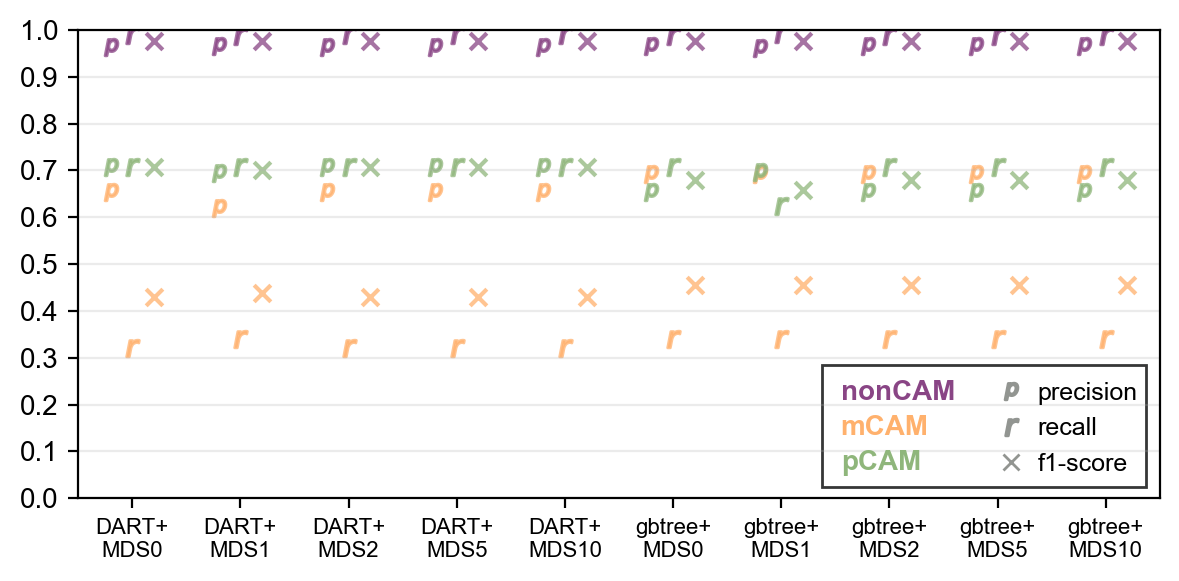

In [25]:
fig, ax = plt.subplots(nrows=1, figsize=(6,3))


for j,pheno in enumerate(["non-CAM","mCAM","pCAM"]):
    ax.scatter(x=[i-0.2 for i in range(len(mdsPredCols))], y=mdsPrecision[j], c=camColorDict[pheno], marker='$p$', alpha=0.75)
    ax.scatter(x=range(len(mdsPredCols)), y=mdsRecall[j], c=camColorDict[pheno], marker='$r$', alpha=0.75)
    ax.scatter(x=[i+0.2 for i in range(len(mdsPredCols))], y=mdsF1[j], c=camColorDict[pheno], marker="x", alpha=0.75)

ax.set_xticks(np.arange(0,len(mdsPredCols),1))
ax.set_xlim(-0.5,len(mdsPredCols)-0.5)
ax.set_xticklabels(["DART+\nMDS0","DART+\nMDS1","DART+\nMDS2","DART+\nMDS5","DART+\nMDS10",
                    "gbtree+\nMDS0","gbtree+\nMDS1","gbtree+\nMDS2","gbtree+\nMDS5","gbtree+\nMDS10",], size=8, rotation=0)
    
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid(axis='y', alpha=0.25)
ax.set_ylim(0,1)

ax.text(s="nonCAM", x=6.55, y=0.225, weight='bold', c=camColorDict['non-CAM'], verticalalignment='center')
ax.text(s="mCAM", x=6.55, y=0.15, weight='bold', c=camColorDict['mCAM'], verticalalignment='center')
ax.text(s="pCAM", x=6.55, y=0.075, weight='bold', c=camColorDict['pCAM'], verticalalignment='center')


precisionSquare = Line2D([0], [0], marker='$p$', color='xkcd:grey', label=r'precision',linestyle="none")
recallCircle = Line2D([0], [0], marker='$r$', color='xkcd:grey', label=r'recall',linestyle="none")
f1Triangle = Line2D([0], [0], marker='x', color='xkcd:grey',  label=r'f1-score',linestyle="none")
ax.legend(handles=[precisionSquare, recallCircle, f1Triangle], frameon=False, loc='lower right', fontsize=9, ncol=1, handletextpad=0.05)

rect = Rectangle(xy=[6.375, 0.025], height=0.26, width=3, edgecolor="xkcd:dark grey", facecolor='None')
ax.add_patch(rect)

plt.tight_layout()
# plt.savefig("../Figures/MDSClassificationMetrics.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

In [26]:
prmList = [prmsMD0dart, prmsMD1dart, prmsMD2dart, prmsMD5dart, prmsMD10dart,
           prmsMD0xgb, prmsMD1xgb, prmsMD2xgb, prmsMD5xgb, prmsMD10xgb]
mErrorsMeans = []
mErrorsStds = []

for p in prmList:
    foo = xgb.cv(params=p, dtrain=dtrain, nfold=10, seed=9999)
    mErrorsMeans.append(foo.iloc[-1][2])
    mErrorsStds.append(foo.iloc[-1][3])

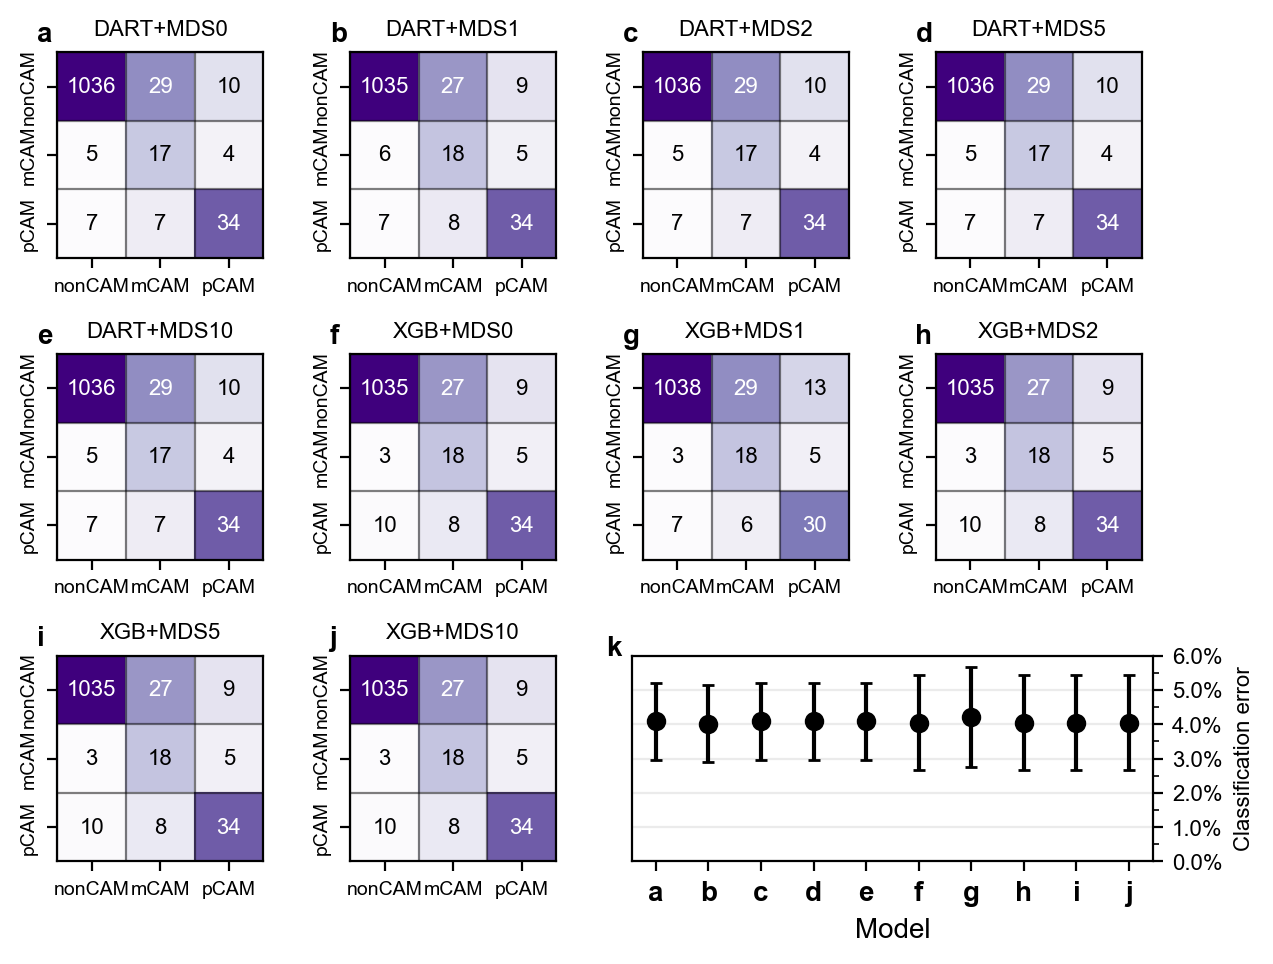

In [27]:
fig,ax = plt.subplot_mosaic(mosaic='''
                                   ABCD
                                   EFGH
                                   IJKK
                                   ''', figsize=(6.5, 6.5*(3/4)))
titles = ["DART+MDS0",
          "DART+MDS1",
          "DART+MDS2",
          "DART+MDS5",
          "DART+MDS10",
          "XGB+MDS0",
          "XGB+MDS1",
          "XGB+MDS2",
          "XGB+MDS5",
          "XGB+MDS10",]

cols = ["ypredMD0dart", "ypredMD1dart", "ypredMD2dart", "ypredMD5dart", "ypredMD10dart",
        "ypredMD0xgb", "ypredMD1xgb", "ypredMD2xgb", "ypredMD5xgb", "ypredMD10xgb"]
# flataxes = ax.flatten()
for i,c in enumerate(cols):
    cMat = metrics.confusion_matrix(X_test[c], X_test["label"])
    cMatNorm = metrics.confusion_matrix(X_test[c], X_test["label"],normalize='pred')
    ax[string.ascii_uppercase[i]].imshow(cMatNorm,cmap="Purples")
    ax[string.ascii_uppercase[i]].set_xticks(np.arange(-0.5,2.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_yticks(np.arange(-0.5,2.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_xticks([0,1,2])
    ax[string.ascii_uppercase[i]].set_yticks([0,1,2])
    ax[string.ascii_uppercase[i]].set_xticklabels(["nonCAM", "mCAM","pCAM",],size=7)
    ax[string.ascii_uppercase[i]].set_yticklabels(["nonCAM", "mCAM","pCAM",],size=7, rotation=90, va="center")
    
    for x in range(len(cMat)):
        for y in range(len(cMat)):
            if cMatNorm[x,y] > 0.5: color="white"
            else: color="black"
            text = ax[string.ascii_uppercase[i]].text(y,x, str(int(cMat[x,y])), ha="center", va="center", color=color, size=8)
    ax[string.ascii_uppercase[i]].set_title(titles[i],size=8)    
    ax[string.ascii_uppercase[i]].tick_params(which="minor", size=0)
    ax[string.ascii_uppercase[i]].grid(which="minor", color="black", alpha=0.5)

for i in range(10):
    ax[string.ascii_uppercase[i]].text(s=string.ascii_lowercase[i], x=-0.1, y=1.05, size=10, transform = ax[string.ascii_uppercase[i]].transAxes, weight='bold')
    
ax['K'].errorbar(x=range(len(cols)), y=mErrorsMeans, yerr=mErrorsStds, linestyle='none', marker="o", color="black", capsize=2)
ax['K'].set_xticks(range(len(cols)))
ax['K'].set_xticklabels(string.ascii_lowercase[:10], weight='bold')
ax['K'].yaxis.tick_right()
ax['K'].yaxis.set_label_position("right")
ax['K'].set_yticks(np.arange(0.0,0.07,0.005), minor=True)
ax['K'].set_yticks(np.arange(0.0,0.07,0.01))
ax['K'].set_yticklabels(["{:1.1%}".format(i) for i in np.arange(0.0,0.07,0.01)], size=8)
ax['K'].set_ylim(0.0,0.06)
ax['K'].set_ylabel("Classification error", size=8)
ax['K'].set_xlabel("Model")
ax['K'].grid(alpha=0.25, axis="y")
ax['K'].text(s='k', x=-0.05, y=1, size=10, transform = ax['K'].transAxes, weight='bold')

plt.tight_layout(pad=1)
# plt.savefig("../Figures/MDSConfusionMatrices.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

##### Over- and under-sampling data

In [28]:
ros = imb.over_sampling.RandomOverSampler(random_state=0)
rus = imb.under_sampling.RandomUnderSampler(random_state=0)

X_ros, y_ros = ros.fit_resample(X_train[dataCols], X_train['label'])
X_rus, y_rus = rus.fit_resample(X_train[dataCols], X_train['label'])

dtrainROS = xgb.DMatrix(data=X_ros, label=y_ros, missing=np.NaN)
dtrainRUS = xgb.DMatrix(data=X_rus, label=y_rus, missing=np.NaN)
dtest = xgb.DMatrix(data=X_test[dataCols], label=X_test["label"], missing=np.NaN)

In [29]:
X_train['label'].value_counts()

0    4268
2     174
1     154
Name: label, dtype: int64

In [30]:
y_ros.value_counts()

0    4268
2    4268
1    4268
Name: label, dtype: int64

In [31]:
y_rus.value_counts()

0    154
1    154
2    154
Name: label, dtype: int64

In [32]:
bstROSdart = xgb.train(prmsDartSprobMerr, dtrainROS, num_round, evalList, verbose_eval=10)
bstRUSdart = xgb.train(prmsDartSprobMerr, dtrainRUS, num_round, evalList, verbose_eval=10)
bstROSxgb = xgb.train(prmsSprobMerr, dtrainROS, num_round, evalList, verbose_eval=10)
bstRUSxgb = xgb.train(prmsSprobMerr, dtrainRUS, num_round, evalList, verbose_eval=10)

[0]	train-merror:0.05831	eval-merror:0.07746
[9]	train-merror:0.04134	eval-merror:0.07137
[0]	train-merror:0.08768	eval-merror:0.08616
[9]	train-merror:0.07811	eval-merror:0.08355
[0]	train-merror:0.06071	eval-merror:0.07746
[9]	train-merror:0.04243	eval-merror:0.07050
[0]	train-merror:0.12903	eval-merror:0.13664
[9]	train-merror:0.08007	eval-merror:0.09138


In [33]:
ypredROSdart = bstROSdart.predict(dtest)
ypredRUSdart = bstRUSdart.predict(dtest)
X_test["ypredROSdart"] = [int(getIndexMax(a)) for a in ypredROSdart]
X_test["ypredRUSdart"] = [int(getIndexMax(a)) for a in ypredRUSdart]

ypredROSxgb = bstROSxgb.predict(dtest)
ypredRUSxgb = bstRUSxgb.predict(dtest)
X_test["ypredROSxgb"] = [int(getIndexMax(a)) for a in ypredROSxgb]
X_test["ypredRUSxgb"] = [int(getIndexMax(a)) for a in ypredRUSxgb]

In [34]:
sampPrecision = []
sampRecall = []
sampF1 = []
sampPredCols = [s for s in X_test.columns if "ROS" in s or "RUS" in s]
for i in range(3):
    sampPrecision.append(flatten([metrics.precision_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in sampPredCols]))
    sampRecall.append(flatten([metrics.recall_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in sampPredCols]))
    sampF1.append(flatten([metrics.f1_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in sampPredCols]))

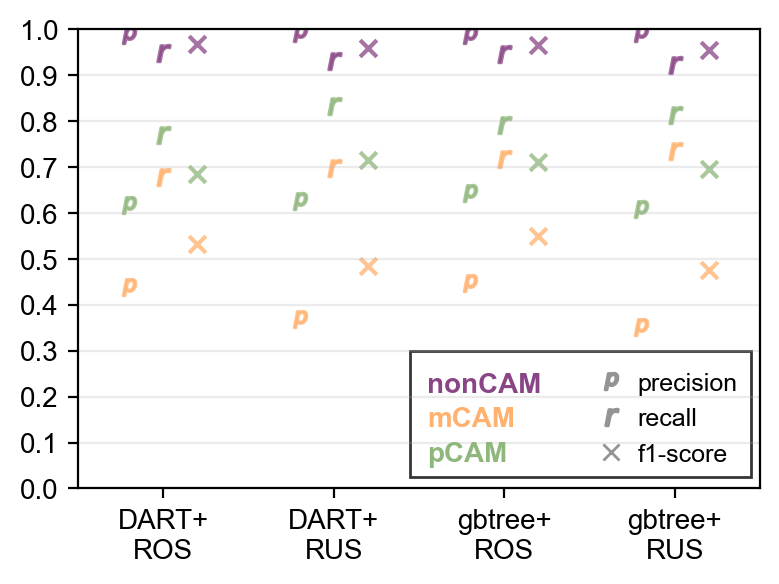

In [35]:
fig, ax = plt.subplots(figsize=(4,3))


for j,pheno in enumerate(["non-CAM","mCAM","pCAM"]):
    ax.scatter(x=[i-0.2 for i in range(len(sampPredCols))], y=sampPrecision[j], c=camColorDict[pheno], marker='$p$', alpha=0.75)
    ax.scatter(x=range(len(sampPredCols)), y=sampRecall[j], c=camColorDict[pheno], alpha=0.75, marker='$r$')
    ax.scatter(x=[i+0.2 for i in range(len(sampPredCols))], y=sampF1[j], c=camColorDict[pheno], marker="x", alpha=0.75)

ax.set_xticks(np.arange(0,len(sampPredCols),1))
ax.set_xlim(-0.5,len(sampPredCols)-0.5)
ax.set_xticklabels(["DART+\nROS","DART+\nRUS","gbtree+\nROS","gbtree+\nRUS"], size=10, rotation=0)
    
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid(axis='y', alpha=0.25)
ax.set_ylim(0,1)

ax.text(s="nonCAM", x=1.55, y=0.225, weight='bold', c=camColorDict['non-CAM'], verticalalignment='center')
ax.text(s="mCAM", x=1.55, y=0.15, weight='bold', c=camColorDict['mCAM'], verticalalignment='center')
ax.text(s="pCAM", x=1.55, y=0.075, weight='bold', c=camColorDict['pCAM'], verticalalignment='center')


precisionSquare = Line2D([0], [0], marker='$p$', color='xkcd:grey', label=r'precision',linestyle="none")
recallCircle = Line2D([0], [0], marker='$r$', color='xkcd:grey', label=r'recall',linestyle="none")
f1Triangle = Line2D([0], [0], marker='x', color='xkcd:grey',  label=r'f1-score',linestyle="none")
ax.legend(handles=[precisionSquare, recallCircle, f1Triangle], frameon=False, loc='lower right', fontsize=9, ncol=1, handletextpad=0.05)

rect = Rectangle(xy=[1.45, 0.025], height=0.275, width=2., edgecolor="xkcd:dark grey", facecolor='None')
ax.add_patch(rect)

plt.tight_layout()
# plt.savefig("../Figures/SamplingClassificationMetrics.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

In [36]:
merrDtrains = [dtrain,dtrainROS,dtrainRUS,
               dtrain,dtrainROS,dtrainRUS]
prms = [prmsDartSprobMerr,prmsDartSprobMerr,prmsDartSprobMerr,
          prmsSprobMerr,prmsSprobMerr,prmsSprobMerr]

mTestErrorsMeans = []
mTestErrorsStds = []
mTrainErrorsMeans = []
mTrainErrorsStds = []

for p,d in zip(prms,merrDtrains):
    foo = xgb.cv(params=p, dtrain=d, nfold=10, seed=9999)
    mTestErrorsMeans.append(foo.iloc[-1][2])
    mTestErrorsStds.append(foo.iloc[-1][3])
    mTrainErrorsMeans.append(foo.iloc[-1][0])
    mTrainErrorsStds.append(foo.iloc[-1][1])

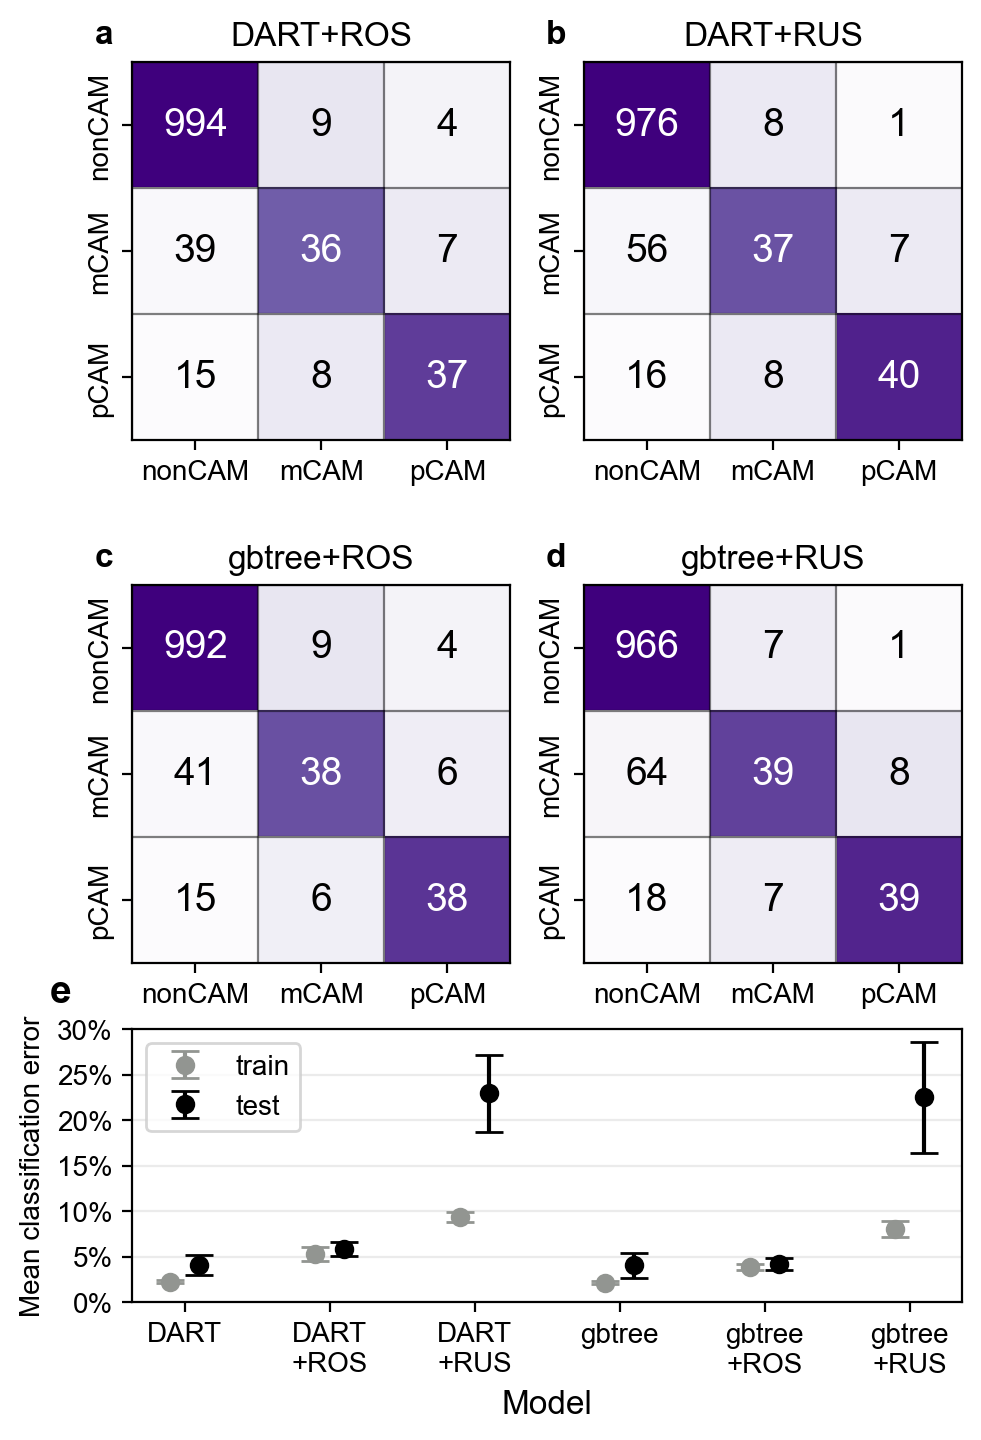

In [37]:
fig,ax = plt.subplot_mosaic(mosaic='''
                                   AABB
                                   AABB
                                   CCDD
                                   CCDD
                                   EEEE
                                   ''', figsize=(5, 5*(3/2)))
titles = ["DART+ROS","DART+RUS","gbtree+ROS","gbtree+RUS",]
cols = ["ypredROSdart", "ypredRUSdart","ypredROSxgb", "ypredRUSxgb",]

for i,c in enumerate(cols):
    cMat = metrics.confusion_matrix(X_test[c], X_test["label"])
    cMatNorm = metrics.confusion_matrix(X_test[c], X_test["label"],normalize='pred')
    ax[string.ascii_uppercase[i]].imshow(cMatNorm,cmap="Purples")
    ax[string.ascii_uppercase[i]].set_xticks(np.arange(-0.5,2.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_yticks(np.arange(-0.5,2.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_xticks([0,1,2])
    ax[string.ascii_uppercase[i]].set_yticks([0,1,2])
    ax[string.ascii_uppercase[i]].set_xticklabels(["nonCAM", "mCAM","pCAM",],size=10)
    ax[string.ascii_uppercase[i]].set_yticklabels(["nonCAM", "mCAM","pCAM",],size=10, rotation=90, va="center")
    
    for x in range(len(cMat)):
        for y in range(len(cMat)):
            if cMatNorm[x,y] > 0.5: color="white"
            else: color="black"
            text = ax[string.ascii_uppercase[i]].text(y,x, str(int(cMat[x,y])), ha="center", va="center", color=color, size=14)
    ax[string.ascii_uppercase[i]].set_title(titles[i],size=12)    
    ax[string.ascii_uppercase[i]].tick_params(which="minor", size=0)
    ax[string.ascii_uppercase[i]].grid(which="minor", color="black", alpha=0.5)

for i in range(4):
    ax[string.ascii_uppercase[i]].text(s=string.ascii_lowercase[i], x=-0.1, y=1.05, size=12, transform = ax[string.ascii_uppercase[i]].transAxes, weight="bold")
    
ax['E'].errorbar(x=[i-0.1 for i in range(len(mTrainErrorsMeans))], y=mTrainErrorsMeans, yerr=mTrainErrorsStds, marker="o", linestyle="none", color="xkcd:grey", label="train", capsize=5)
ax['E'].errorbar(x=[i+0.1 for i in range(len(mTrainErrorsMeans))], y=mTestErrorsMeans, yerr=mTestErrorsStds, marker="o", linestyle="none", color="black", label="test", capsize=5)
ax['E'].set_xticks(range(len(mTestErrorsMeans)))
ax['E'].set_xticklabels(["DART","DART\n+ROS","DART\n+RUS","gbtree","gbtree\n+ROS","gbtree\n+RUS",], size=10)
ax['E'].set_yticks(np.arange(0,0.35,0.05))
ax['E'].set_yticklabels(["{:1.0%}".format(i) for i in np.arange(0,0.35,0.05)])
ax['E'].set_ylim(0,0.3)
ax['E'].set_ylabel("Mean classification error", size=10)
ax['E'].set_xlabel("Model", size=12)
ax['E'].grid(alpha=0.25, axis="y")
ax['E'].text(s='e', x=-0.1, y=1.1, size=14, transform = ax['E'].transAxes, weight="bold")
ax['E'].legend(loc="upper left")

plt.tight_layout(h_pad=-2.5)
# plt.savefig("../Figures/ROS-RUS-ConfusionMatrices.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

In [38]:
print(metrics.classification_report(y_pred=X_test['ypredROSxgb'], y_true=X_test["label"]))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1048
           1       0.45      0.72      0.55        53
           2       0.64      0.79      0.71        48

    accuracy                           0.93      1149
   macro avg       0.69      0.82      0.74      1149
weighted avg       0.95      0.93      0.94      1149



In [39]:
print(metrics.classification_report(y_pred=X_test['ypredROSdart'], y_true=X_test["label"]))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1048
           1       0.44      0.68      0.53        53
           2       0.62      0.77      0.69        48

    accuracy                           0.93      1149
   macro avg       0.68      0.80      0.73      1149
weighted avg       0.95      0.93      0.94      1149



In [40]:
rosXgbMisclassified = X_test[X_test["ypredROSxgb"]!=X_test["label"]]
rosDartMisclassified = X_test[X_test["ypredROSdart"]!=X_test["label"]]
print(rosXgbMisclassified.shape,rosDartMisclassified.shape)

(81, 42) (82, 42)


#### Imputing missing data
After going through the accuracy tests and seeing little to now differences among boosters and objective functions, I'll stick with a pretty vanilla parameter set and try out a few imputation methods. I like the `merror` objective function because it is easy to interpret.

In [41]:
iterImp  = impute.IterativeImputer(max_iter=1000, random_state=9999)
iterImp.fit(X_train[dataCols])
iterTrainImputed = pd.DataFrame(iterImp.transform(X_train[dataCols]), columns=dataCols)
iterTrainImputed["Taxon"] = X_train["Taxon"]
iterTrainImputed["label"] = X_train["label"]
iterTestImputed = pd.DataFrame(iterImp.transform(X_test[dataCols]), columns=dataCols)
iterTestImputed["Taxon"] = X_test["Taxon"]
iterTestImputed["label"] = X_test["label"]
dtrainIter = xgb.DMatrix(data=iterTrainImputed[dataCols], label=iterTrainImputed["label"], missing=np.NaN)
dtestIter = xgb.DMatrix(data=iterTestImputed[dataCols], label=iterTestImputed["label"], missing=np.NaN)

knnImp  = impute.KNNImputer(n_neighbors=5, weights="uniform")
knnImp.fit(X_train[dataCols])
knnTrainImputed = pd.DataFrame(knnImp.transform(X_train[dataCols]), columns=dataCols)
knnTrainImputed["Taxon"] = X_train["Taxon"]
knnTrainImputed["label"] = X_train["label"]
knnTestImputed = pd.DataFrame(knnImp.transform(X_test[dataCols]), columns=dataCols)
knnTestImputed["Taxon"] = X_test["Taxon"]
knnTestImputed["label"] = X_test["label"]
dtrainKnn = xgb.DMatrix(data=knnTrainImputed[dataCols], label=knnTrainImputed["label"], missing=np.NaN)
dtestKnn = xgb.DMatrix(data=knnTestImputed[dataCols], label=knnTestImputed["label"], missing=np.NaN)

medImp  = impute.SimpleImputer(strategy='median')
medImp.fit(X_train[dataCols])
medTrainImputed = pd.DataFrame(medImp.transform(X_train[dataCols]), columns=dataCols)
medTrainImputed["Taxon"] = X_train["Taxon"]
medTrainImputed["label"] = X_train["label"]
medTestImputed = pd.DataFrame(medImp.transform(X_test[dataCols]), columns=dataCols)
medTestImputed["Taxon"] = X_test["Taxon"]
medTestImputed["label"] = X_test["label"]
dtrainMed = xgb.DMatrix(data=medTrainImputed[dataCols], label=medTrainImputed["label"], missing=np.NaN)
dtestMed = xgb.DMatrix(data=medTestImputed[dataCols], label=medTestImputed["label"], missing=np.NaN)

#### Training

In [42]:
num_round = 10
bstIterSmaxMerrDart = xgb.train(prmsDartSprobMerr, dtrainIter, num_round, evalList, verbose_eval=10)
bstKnnSmaxMerrDart = xgb.train(prmsDartSprobMerr, dtrainKnn, num_round, evalList, verbose_eval=10)
bstMedSmaxMerrDart = xgb.train(prmsDartSprobMerr, dtrainMed, num_round, evalList, verbose_eval=10)

bstIterSmaxMerrXgb = xgb.train(prmsSprobMerr, dtrainIter, num_round, evalList, verbose_eval=10)
bstKnnSmaxMerrXgb = xgb.train(prmsSprobMerr, dtrainKnn, num_round, evalList, verbose_eval=10)
bstMedSmaxMerrXgb = xgb.train(prmsSprobMerr, dtrainMed, num_round, evalList, verbose_eval=10)

[0]	train-merror:0.84443	eval-merror:0.84682
[9]	train-merror:0.92167	eval-merror:0.92254
[0]	train-merror:0.07419	eval-merror:0.08529
[9]	train-merror:0.49325	eval-merror:0.52132
[0]	train-merror:0.04243	eval-merror:0.06353
[9]	train-merror:0.04134	eval-merror:0.06702
[0]	train-merror:0.93016	eval-merror:0.93821
[9]	train-merror:0.83246	eval-merror:0.84160
[0]	train-merror:0.35052	eval-merror:0.35422
[9]	train-merror:0.37707	eval-merror:0.42124
[0]	train-merror:0.04417	eval-merror:0.06875
[9]	train-merror:0.03960	eval-merror:0.06614


#### Prediction

In [43]:
ypredSmaxIterDart = bstIterSmaxMerrDart.predict(dtestIter)
ypredSmaxKnnDart = bstKnnSmaxMerrDart.predict(dtestKnn)
ypredSmaxMedDart = bstMedSmaxMerrDart.predict(dtestMed)

ypredSmaxIterXgb = bstIterSmaxMerrXgb.predict(dtestIter)
ypredSmaxKnnXgb = bstKnnSmaxMerrXgb.predict(dtestKnn)
ypredSmaxMedXgb = bstMedSmaxMerrXgb.predict(dtestMed)

X_test["ypredIterDart"] = [int(getIndexMax(a)) for a in ypredSmaxIterDart]
X_test["ypredKnnDart"] = [int(getIndexMax(a)) for a in ypredSmaxKnnDart]
X_test["ypredMedDart"] = [int(getIndexMax(a)) for a in ypredSmaxMedDart]

X_test["ypredIterXgb"] = [int(getIndexMax(a)) for a in ypredSmaxIterXgb]
X_test["ypredKnnXgb"] = [int(getIndexMax(a)) for a in ypredSmaxKnnXgb]
X_test["ypredMedXgb"] = [int(getIndexMax(a)) for a in ypredSmaxMedXgb]
predCols = sorted([c for c in X_test if "ypred" in c])

#### Accuracy

In [44]:
impPrecision = []
impRecall = []
impF1 = []
impPredCols = [s for s in X_test.columns if "Iter" in s or "Knn" in s or "Med" in s]
for i in range(3):
    impPrecision.append(flatten([metrics.precision_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in impPredCols]))
    impRecall.append(flatten([metrics.recall_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in impPredCols]))
    impF1.append(flatten([metrics.f1_score(y_true=X_test["label"], y_pred=X_test[p], labels=[i], average=None) for p in impPredCols]))

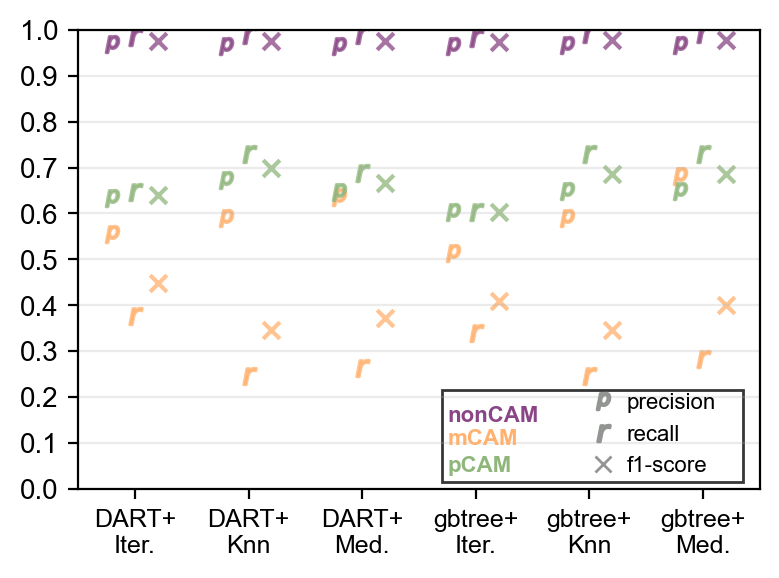

In [45]:
fig, ax = plt.subplots(figsize=(4,3))


for j,pheno in enumerate(["non-CAM","mCAM","pCAM"]):
    ax.scatter(x=[i-0.2 for i in range(len(impPredCols))], y=impPrecision[j], c=camColorDict[pheno], marker="$p$", alpha=0.75)
    ax.scatter(x=range(len(impPredCols)), y=impRecall[j], c=camColorDict[pheno], alpha=0.75, marker="$r$")
    ax.scatter(x=[i+0.2 for i in range(len(impPredCols))], y=impF1[j], c=camColorDict[pheno], marker="x", alpha=0.75)

ax.set_xticks(np.arange(0,len(impPredCols),1))
ax.set_xlim(-0.5,len(impPredCols)-0.5)
ax.set_xticklabels(["DART+\nIter.","DART+\nKnn","DART+\nMed.","gbtree+\nIter.","gbtree+\nKnn","gbtree+\nMed."], size=9, rotation=0)
    
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid(axis='y', alpha=0.25)
ax.set_ylim(0,1)

ax.text(s="nonCAM", x=2.75, y=0.16, weight='bold', c=camColorDict['non-CAM'], verticalalignment='center',size=8)
ax.text(s="mCAM", x=2.75, y=0.11, weight='bold', c=camColorDict['mCAM'], verticalalignment='center',size=8)
ax.text(s="pCAM", x=2.75, y=0.05, weight='bold', c=camColorDict['pCAM'], verticalalignment='center',size=8)


precisionSquare = Line2D([0], [0], marker='$p$', color='xkcd:grey', label=r'precision',linestyle="none",)
recallCircle = Line2D([0], [0], marker='$r$', color='xkcd:grey', label=r'recall',linestyle="none")
f1Triangle = Line2D([0], [0], marker='x', color='xkcd:grey',  label=r'f1-score',linestyle="none")
ax.legend(handles=[precisionSquare, recallCircle, f1Triangle], frameon=False, loc=[0.725,0.01], fontsize=8, ncol=1, handletextpad=0.05)

rect = Rectangle(xy=[2.7, 0.015], height=0.2, width=2.65, edgecolor="xkcd:dark grey", facecolor='None', )
ax.add_patch(rect)

plt.tight_layout()
# plt.savefig("../Figures/ImputeClassificationMetrics.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

In [46]:
merrDtrains = [dtrain, dtrainIter, dtrainKnn, dtrainMed,
               dtrain, dtrainIter, dtrainKnn, dtrainMed]
prms = [prmsDartSprobMerr,prmsDartSprobMerr,prmsDartSprobMerr,prmsDartSprobMerr,
        prmsSprobMerr,prmsSprobMerr,prmsSprobMerr,prmsSprobMerr]
    
mTestErrorsMeans = []
mTestErrorsStds = []
mTrainErrorsMeans = []
mTrainErrorsStds = []

for p,d in zip(prms,merrDtrains):
    foo = xgb.cv(params=p, dtrain=d, nfold=10, seed=9999)
    mTestErrorsMeans.append(foo.iloc[-1][2])
    mTestErrorsStds.append(foo.iloc[-1][3])
    mTrainErrorsMeans.append(foo.iloc[-1][0])
    mTrainErrorsStds.append(foo.iloc[-1][1])

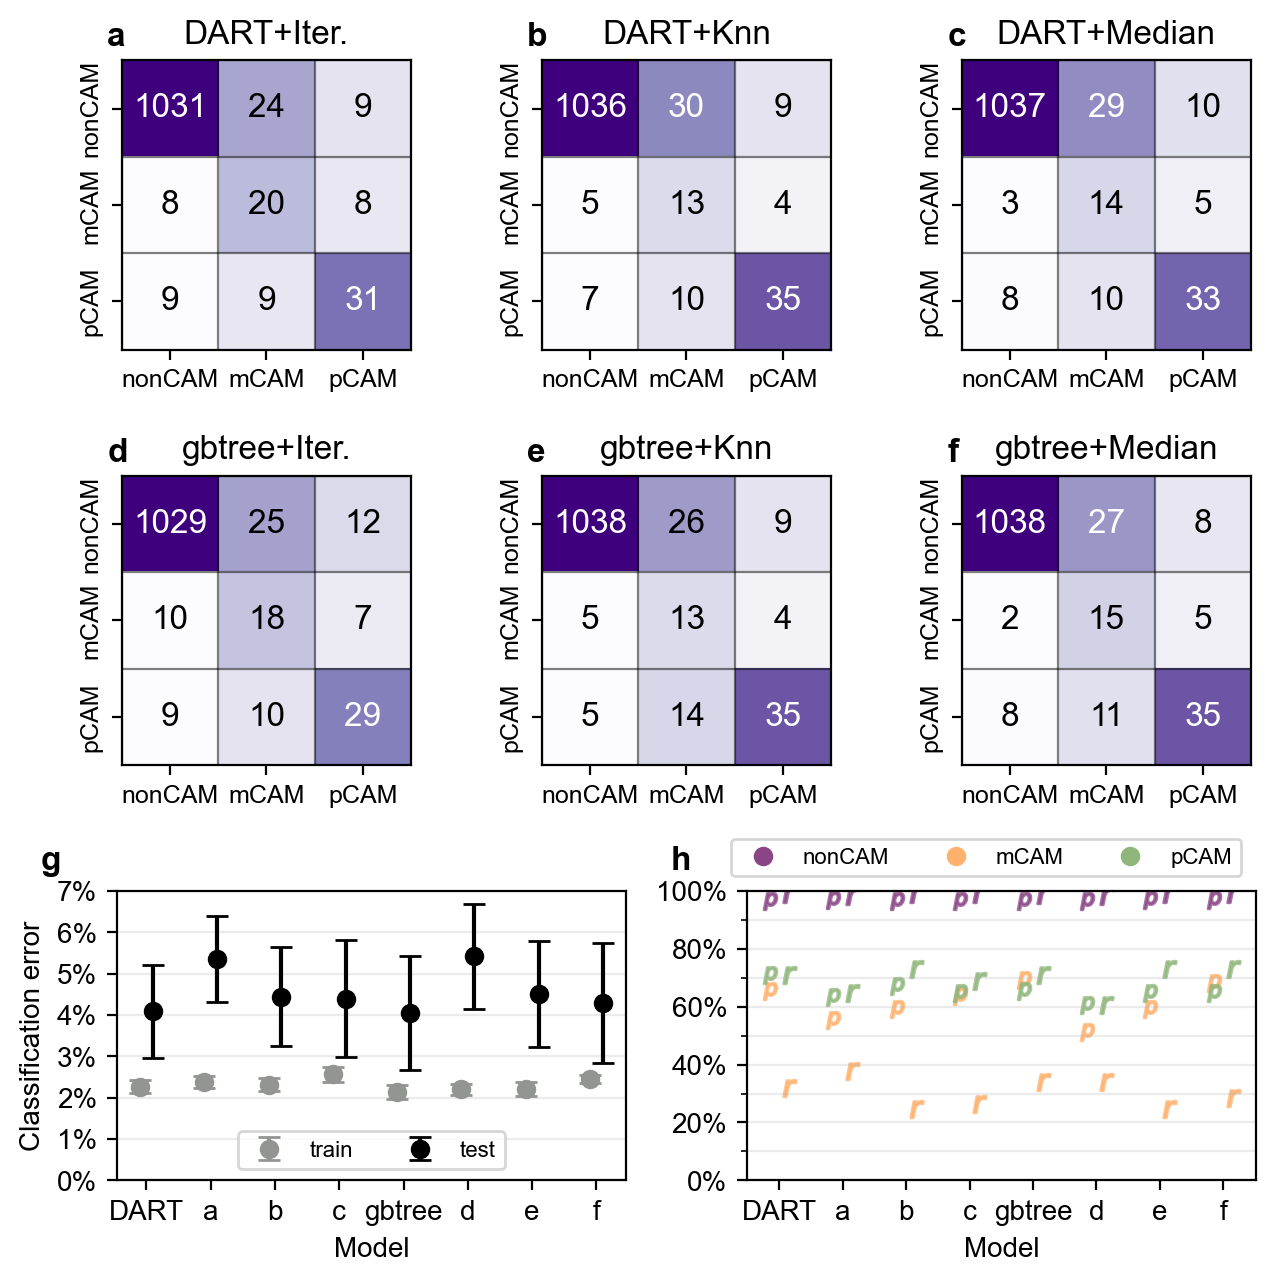

In [47]:
fig,ax = plt.subplot_mosaic(mosaic='''
                                   AABBCC
                                   DDEEFF
                                   GGGHHH
                                   ''', figsize=(6.5, 6.5))

titles = ["DART+Iter.","DART+Knn","DART+Median",
          "gbtree+Iter.","gbtree+Knn","gbtree+Median",]
cols = ['ypredIterDart', 'ypredKnnDart','ypredMedDart',
        'ypredIterXgb', 'ypredKnnXgb', 'ypredMedXgb']

phenoAccs = []
for i,c in enumerate(cols):
    cMat = metrics.confusion_matrix(X_test[c], X_test["label"])
    cMatNorm = metrics.confusion_matrix(X_test[c], X_test["label"],normalize='pred')
    
    if i==0:
        phenoAccs.append(np.diag(metrics.confusion_matrix(X_test["ypredDartSprobMerr"], X_test["label"],normalize='pred')))
    if i==3:
        phenoAccs.append(np.diag(metrics.confusion_matrix(X_test["ypredSprobMerr"], X_test["label"],normalize='pred')))
    phenoAccs.append(np.diag(cMatNorm))

    ax[string.ascii_uppercase[i]].imshow(cMatNorm,cmap="Purples")
    ax[string.ascii_uppercase[i]].set_xticks(np.arange(-0.5,2.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_yticks(np.arange(-0.5,2.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_xticks([0,1,2])
    ax[string.ascii_uppercase[i]].set_yticks([0,1,2])
    ax[string.ascii_uppercase[i]].set_xticklabels(["nonCAM", "mCAM","pCAM",],size=9)
    ax[string.ascii_uppercase[i]].set_yticklabels(["nonCAM", "mCAM","pCAM",],size=9, rotation=90, va="center")
    
    for x in range(len(cMat)):
        for y in range(len(cMat)):
            if cMatNorm[x,y] > 0.5: color="white"
            else: color="black"
            text = ax[string.ascii_uppercase[i]].text(y,x, str(int(cMat[x,y])), ha="center", va="center", color=color, size=12)
    ax[string.ascii_uppercase[i]].set_title(titles[i],size=12)    
    ax[string.ascii_uppercase[i]].tick_params(which="minor", size=0)
    ax[string.ascii_uppercase[i]].grid(which="minor", color="black", alpha=0.5)
    ax[string.ascii_uppercase[i]].text(s=string.ascii_lowercase[i], x=-0.05, y=1.05, size=12, transform = ax[string.ascii_uppercase[i]].transAxes, weight="bold")
   
ax['G'].errorbar(x=[i-0.1 for i in range(len(cols)+2)], y=mTrainErrorsMeans, yerr=mTrainErrorsStds, marker="o", linestyle='none', color="xkcd:grey", label="train", capsize=4)
ax['G'].errorbar(x=[i+0.1 for i in range(len(cols)+2)], y=mTestErrorsMeans, yerr=mTestErrorsStds, marker="o",  linestyle='none', color="black", label="test", capsize=4)
ax['G'].set_xticks(range(len(cols)+2))
ax['G'].set_xticklabels(["DART","a","b","c","gbtree","d","e","f"], size=10)
ax['G'].set_yticks(np.arange(0,0.1,0.01))
ax['G'].set_yticklabels(["{:1.0%}".format(i) for i in np.arange(0,0.1,0.01)])
ax['G'].set_ylim(0,0.07)
ax['G'].set_ylabel("Classification error", size=10)
ax['G'].set_xlabel("Model", size=10)
ax['G'].grid(alpha=0.25, axis="y")
ax['G'].legend(frameon=True, loc='lower center', fontsize=8, ncol=2)
ax['G'].text(s='g', x=-0.15, y=1.075, size=12, transform = ax['G'].transAxes, weight="bold")

phenoAccs = np.array(phenoAccs)
ax['H'].set_yticks(np.arange(0.0,1.1,0.1), minor=True)
ax['H'].set_yticks(np.arange(0.0,1.2,0.2))
ax['H'].set_yticklabels(["{:1.0%}".format(i) for i in np.arange(0.0,1.2,0.2)])
ax['H'].set_ylim(0,1.0)
for j,pheno in enumerate(["non-CAM","mCAM","pCAM"]):
    ax['H'].scatter(x=[i-0.15 for i in range(len(impPredCols)+2)], y=[basePrecision[j][0]] + impPrecision[j][:3] + [basePrecision[j][5]] + impPrecision[j][3:], 
                    c=camColorDict[pheno], marker="$p$", alpha=0.75)
    ax['H'].scatter(x=[i+0.15 for i in range(len(impPredCols)+2)], y=[baseRecall[j][0]] + impRecall[j][:3] + [baseRecall[j][5]] + impRecall[j][3:], 
                    c=camColorDict[pheno], alpha=0.75, marker="$r$")
# ax['H'].scatter(x=range(len(cols)+2), y=phenoAccs[:,0],color=nonCAMcolor, alpha=0.5, label="nonCAM")
# ax['H'].scatter(x=range(len(cols)+2), y=phenoAccs[:,1],color=nonpCAMcolor, alpha=0.5, label="mCAM")
# ax['H'].scatter(x=range(len(cols)+2), y=phenoAccs[:,2],color=pCAMcolor, alpha=0.5, label="pCAM")
ax['H'].set_xticks(range(len(cols)+2))
ax['H'].set_xticklabels(["DART","a","b","c","gbtree","d","e","f"], size=10)
ax['H'].set_xlabel("Model", size=10)
ax['H'].grid(alpha=0.25, axis="y", which="both")

purpleDot = Line2D([0], [0], marker='o', color=nonCAMcolor, label=r'nonCAM',linestyle="none")
yellowDot = Line2D([0], [0], marker='o', color=nonpCAMcolor, label=r'mCAM',linestyle="none")
greenDot = Line2D([0], [0], marker='o', color=pCAMcolor,  label=r'pCAM',linestyle="none")
ax['H'].legend(handles=[purpleDot,yellowDot,greenDot], frameon=True, loc=(-0.03, 1.05), fontsize=8, ncol=3)
ax['H'].text(s='h', x=-0.15, y=1.075, size=12, transform = ax['H'].transAxes, weight="bold")

plt.tight_layout()
# plt.savefig("../Figures/ImputationAccuracy.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

## Treating CAM as a binary trait

In [48]:
toBinary = {"non-CAM":0, "mCAM":1, "pCAM":1}
morpho["binLabel"] = [toBinary[p] for p in morpho["CAMpheno"]]
logMorpho["binLabel"] = [toBinary[p] for p in logMorpho["CAMpheno"]]

In [49]:
binX_train, binX_test = train_test_split(logMorpho, test_size=0.2, random_state=4321)
binX_train = binX_train.sort_values("Taxon").reset_index(drop=True)
binX_test = binX_test.sort_values("Taxon").reset_index(drop=True)
binDtrain = xgb.DMatrix(data=binX_train[dataCols], label=binX_train["binLabel"], missing=np.NaN)
binDtest = xgb.DMatrix(data=binX_test[dataCols], label=binX_test["binLabel"], missing=np.NaN)

#### Classifier parameters
I'm going to stick with our best parameter settings from above, where possible.

In [50]:
prmsBinLogit = {'tree_method':'exact','objective':'binary:logistic','nthread':-1,'subsample':0.75,'eval_metric':'error','booster':'dart'}
prmsBinRaw = {'tree_method':'exact','objective':'binary:logitraw','nthread':-1,'subsample':0.75,'eval_metric':'error','booster':'dart'} 
prmsBinHinge = {'tree_method':'exact','objective':'binary:hinge','nthread':-1,'subsample':0.75,'eval_metric':'error','booster':'dart'}
binEvalList = [(binDtrain, 'train'), (binDtest, 'eval')]

#### ROS

In [51]:
binX_ros, biny_ros = ros.fit_resample(binX_train[dataCols], binX_train['binLabel'])
binDtrainROS = xgb.DMatrix(data=binX_ros, label=biny_ros, missing=np.NaN)
binDtestROS = xgb.DMatrix(data=binX_test[dataCols], label=binX_test["binLabel"], missing=np.NaN)

#### Training

In [52]:
bstBinLogit = xgb.train(prmsBinLogit, binDtrain, num_round, evalList, verbose_eval=10)
bstBinRaw = xgb.train(prmsBinRaw, binDtrain, num_round, evalList, verbose_eval=10)
bstBinHinge = xgb.train(prmsBinHinge, binDtrain, num_round, evalList, verbose_eval=10)

bstBinLogitROS = xgb.train(prmsBinLogit, binDtrainROS, num_round, evalList, verbose_eval=10)
bstBinRawROS = xgb.train(prmsBinRaw, binDtrainROS, num_round, evalList, verbose_eval=10)
bstBinHingeROS = xgb.train(prmsBinHinge, binDtrainROS, num_round, evalList, verbose_eval=10)

[0]	train-error:-0.00239	eval-error:0.01044
[9]	train-error:-0.01262	eval-error:-0.00348
[0]	train-error:0.00435	eval-error:0.02959
[9]	train-error:-0.00130	eval-error:0.01218
[0]	train-error:0.89077	eval-error:0.87032
[9]	train-error:-0.01567	eval-error:-0.01567
[0]	train-error:0.00805	eval-error:0.00261
[9]	train-error:-0.00479	eval-error:-0.00348
[0]	train-error:0.00805	eval-error:0.00261
[9]	train-error:-0.00740	eval-error:-0.01044
[0]	train-error:0.89077	eval-error:0.87032
[9]	train-error:-0.00762	eval-error:-0.01044


#### Prediction

In [53]:
ypredBinLogit = bstBinLogit.predict(binDtest)
ypredBinRaw = bstBinRaw.predict(binDtest)
ypredBinHinge = bstBinHinge.predict(binDtest)

ypredBinLogitROS = bstBinLogitROS.predict(binDtestROS)
ypredBinRawROS = bstBinRawROS.predict(binDtestROS)
ypredBinHingeROS = bstBinHingeROS.predict(binDtestROS)

binX_test["ypredBinLogit"] = [round(x) for x in ypredBinLogit]
binX_test["ypredBinRaw"] = [0 if np.sign(x)==-1 else 1 for x in ypredBinRaw]
binX_test["ypredBinHinge"] = ypredBinHinge

binX_test["ypredBinLogitROS"] = [round(x) for x in ypredBinLogitROS]
binX_test["ypredBinRawROS"] = [0 if np.sign(x)==-1 else 1 for x in ypredBinRawROS]
binX_test["ypredBinHingeROS"] = ypredBinHingeROS
binPredCols = sorted([c for c in binX_test if "ypredBin" in c])

#### Accuracy

In [54]:
binPrecision = []
binRecall = []
binF1 = []
binPredCols = [s for s in binX_test.columns if "Bin" in s]
for i in range(2):
    binPrecision.append(flatten([metrics.precision_score(y_true=binX_test["binLabel"], y_pred=binX_test[p], average=None, labels=[i]) for p in binPredCols]))
    binRecall.append(flatten([metrics.recall_score(y_true=binX_test["binLabel"], y_pred=binX_test[p], average=None, labels=[i]) for p in binPredCols]))
    binF1.append(flatten([metrics.f1_score(y_true=binX_test["binLabel"], y_pred=binX_test[p], average=None, labels=[i]) for p in binPredCols]))

In [55]:
binCAMcolorDict = {"non-CAM":nonCAMcolor, "CAM":"xkcd:sea"}

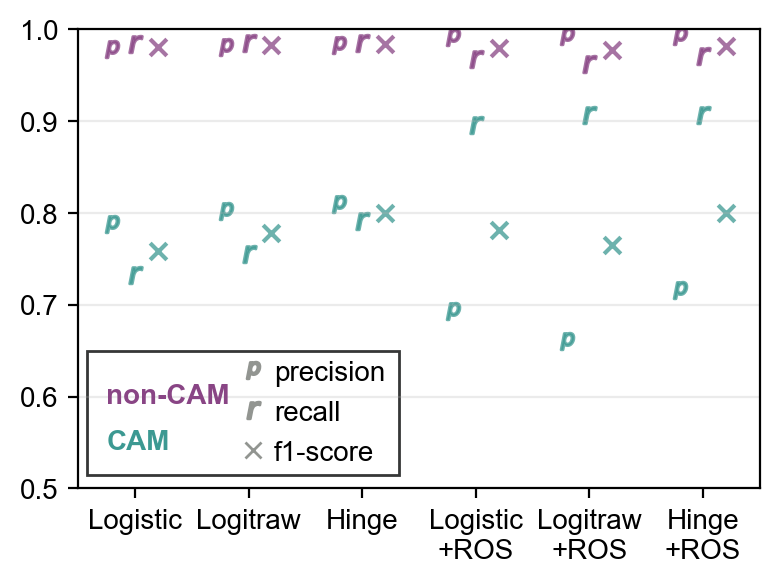

In [56]:
fig, ax = plt.subplots(figsize=(4,3))

for j,pheno in enumerate(["non-CAM","CAM"]):
    ax.scatter(x=[i-0.2 for i in range(len(binPredCols))], y=binPrecision[j], c=binCAMcolorDict[pheno], marker='$p$', alpha=0.75)
    ax.scatter(x=range(len(binPredCols)), y=binRecall[j], c=binCAMcolorDict[pheno], alpha=0.75, marker='$r$')
    ax.scatter(x=[i+0.2 for i in range(len(binPredCols))], y=binF1[j], c=binCAMcolorDict[pheno], marker="x", alpha=0.75)

ax.set_xticks(np.arange(0,len(binPredCols),1))
ax.set_xlim(-0.5,len(binPredCols)-0.5)
ax.set_xticklabels(["Logistic","Logitraw","Hinge","Logistic\n+ROS","Logitraw\n+ROS","Hinge\n+ROS"], size=10, rotation=0)
    
ax.set_yticks(np.arange(0,1.1,0.1))
ax.grid(axis='y', alpha=0.25)
ax.set_ylim(0.5,1)

ax.text(s="non-CAM", x=-0.25, y=0.60, weight='bold', c=binCAMcolorDict['non-CAM'], verticalalignment='center')
ax.text(s="CAM", x=-0.25, y=0.55, weight='bold', c=binCAMcolorDict['CAM'], verticalalignment='center')

precisionSquare = Line2D([0], [0], marker='$p$', color='xkcd:grey', label=r'precision',linestyle="none")
recallCircle = Line2D([0], [0], marker='$r$', color='xkcd:grey', label=r'recall',linestyle="none")
f1Triangle = Line2D([0], [0], marker='x', color='xkcd:grey',  label=r'f1-score',linestyle="none")
ax.legend(handles=[precisionSquare, recallCircle, f1Triangle], frameon=False, loc=[0.2,0.025], fontsize=10, ncol=1, handletextpad=-0.25, )

rect = Rectangle(xy=[-0.425, 0.515], height=0.135, width=2.75, edgecolor="xkcd:dark grey", facecolor='None')
ax.add_patch(rect)

plt.tight_layout()
# plt.savefig("../Figures/BinaryClassificationMetrics.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

In [57]:
print(metrics.classification_report(y_true=binX_test["binLabel"], y_pred=binX_test["ypredBinHinge"]))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1063
           1       0.81      0.79      0.80        86

    accuracy                           0.97      1149
   macro avg       0.90      0.89      0.89      1149
weighted avg       0.97      0.97      0.97      1149



In [58]:
print(metrics.classification_report(y_true=binX_test["binLabel"], y_pred=binX_test["ypredBinHingeROS"]))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1063
           1       0.72      0.91      0.80        86

    accuracy                           0.97      1149
   macro avg       0.85      0.94      0.89      1149
weighted avg       0.97      0.97      0.97      1149



In [59]:
binErrDtrains = [binDtrain, binDtrain, binDtrain,binDtrainROS, binDtrainROS, binDtrainROS]
binPrms = [prmsBinLogit,prmsBinRaw,prmsBinHinge, prmsBinLogit,prmsBinRaw,prmsBinHinge,]
    
binTestErrorsMeans = []
binTestErrorsStds = []
binTrainErrorsMeans = []
binTrainErrorsStds = []

for p,d in zip(binPrms,binErrDtrains):
    foo = xgb.cv(params=p, dtrain=d, nfold=10, seed=9999)
    binTestErrorsMeans.append(foo.iloc[-1][2])
    binTestErrorsStds.append(foo.iloc[-1][3])
    binTrainErrorsMeans.append(foo.iloc[-1][0])
    binTrainErrorsStds.append(foo.iloc[-1][1])

In [60]:
xgb.cv(params=prmsSprobMerr, dtrain=dtrainROS, nfold=10, seed=9999).iloc[-1]

train-merror-mean    0.039102
train-merror-std     0.003454
test-merror-mean     0.042488
test-merror-std      0.006626
Name: 9, dtype: float64

In [61]:
binTestErrorsStds

[0.0053275515727208116,
 0.006581847919847434,
 0.005648412095447711,
 0.005865717112169662,
 0.0035297956938043873,
 0.004785680369602633]

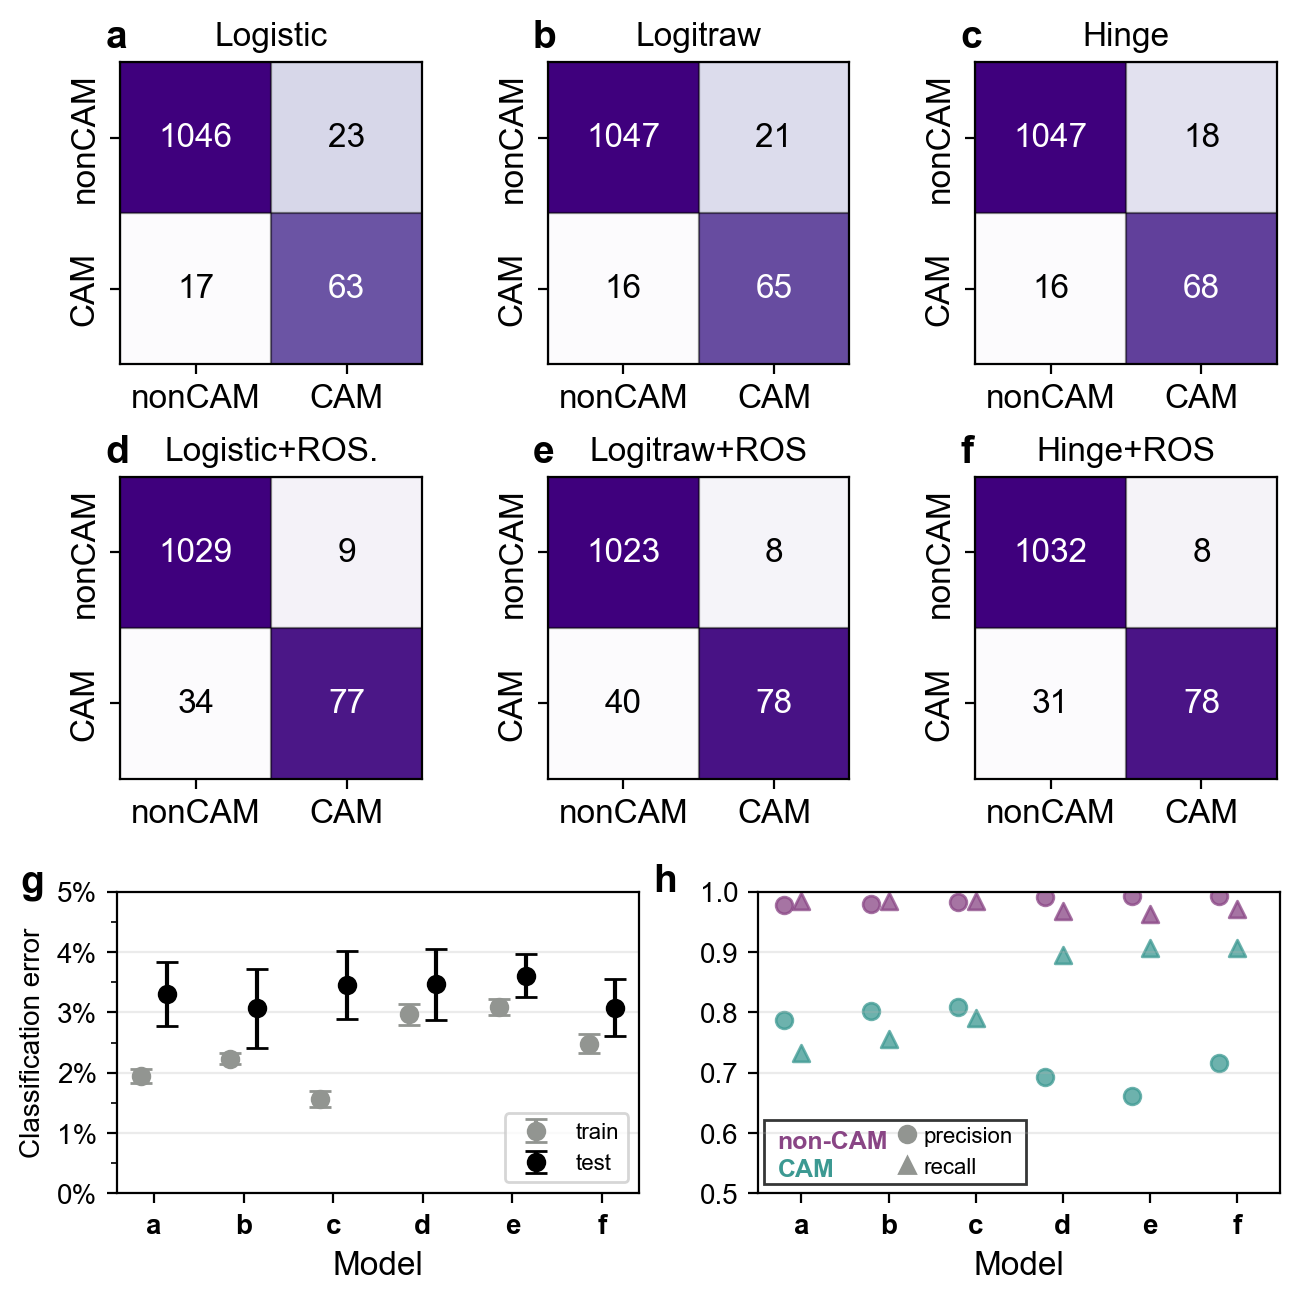

In [62]:
fig,ax = plt.subplot_mosaic(mosaic='''
                                   AABBCC
                                   DDEEFF
                                   GGGHHH
                                   ''', figsize=(6.5, 6.5))

titles = ["Logistic","Logitraw","Hinge",
          "Logistic+ROS.","Logitraw+ROS","Hinge+ROS",]
cols = ['ypredBinLogit', 'ypredBinRaw','ypredBinHinge',
        'ypredBinLogitROS', 'ypredBinRawROS', 'ypredBinHingeROS']

camColor = "xkcd:sea"

phenoAccs = []
for i,c in enumerate(cols):
    cMat = metrics.confusion_matrix(binX_test[c], binX_test["binLabel"])
    cMatNorm = metrics.confusion_matrix(binX_test[c], binX_test["binLabel"],normalize='pred')
    phenoAccs.append(np.diag(cMatNorm))

    ax[string.ascii_uppercase[i]].imshow(cMatNorm,cmap="Purples")
    ax[string.ascii_uppercase[i]].set_xticks(np.arange(-0.5,1.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_yticks(np.arange(-0.5,1.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_xticks([0,1])
    ax[string.ascii_uppercase[i]].set_yticks([0,1])
    ax[string.ascii_uppercase[i]].set_xticklabels(["nonCAM", "CAM",],size=12)
    ax[string.ascii_uppercase[i]].set_yticklabels(["nonCAM", "CAM",],size=12, rotation=90, va="center")
    
    for x in range(len(cMat)):
        for y in range(len(cMat)):
            if cMatNorm[x,y] > 0.5: color="white"
            else: color="black"
            text = ax[string.ascii_uppercase[i]].text(y,x, str(int(cMat[x,y])), ha="center", va="center", color=color, size=12)
    ax[string.ascii_uppercase[i]].set_title(titles[i],size=12)    
    ax[string.ascii_uppercase[i]].tick_params(which="minor", size=0)
    ax[string.ascii_uppercase[i]].grid(which="minor", color="black", alpha=0.5)
    ax[string.ascii_uppercase[i]].text(s=string.ascii_lowercase[i], x=-0.05, y=1.05, size=14, transform = ax[string.ascii_uppercase[i]].transAxes, weight="bold")
   
ax['G'].errorbar(x=[i-0.15 for i in range(len(cols))], y=binTrainErrorsMeans, yerr=binTrainErrorsStds, linestyle='none', marker="o", color="xkcd:grey", label="train", capsize=4)
ax['G'].errorbar(x=[i+0.15 for i in range(len(cols))], y=binTestErrorsMeans, yerr=binTestErrorsStds, linestyle='none', marker="o", color="black", label="test", capsize=4)
ax['G'].set_xticks(range(len(cols)))
ax['G'].set_xticklabels(["a","b","c","d","e","f"], size=10, weight="bold")
ax['G'].set_yticks(np.arange(0,0.1,0.01))
ax['G'].set_yticks(np.arange(0,0.1,0.005), minor=True)
ax['G'].set_yticklabels(["{:1.0%}".format(i) for i in np.arange(0,0.1,0.01)])
ax['G'].set_ylim(0.0,0.05)
ax['G'].set_ylabel("Classification error", size=10)
ax['G'].set_xlabel("Model", size=12)
ax['G'].grid(alpha=0.25, axis="y")
ax['G'].legend(frameon=True, loc="lower right", fontsize=8, ncol=1)
ax['G'].text(s='g', x=-0.185, y=1.0, size=14, transform = ax['G'].transAxes, weight="bold")

# phenoAccs = np.array(phenoAccs)
# ax['H'].set_yticks(np.arange(0.0,1.1,0.1), minor=True)
# ax['H'].set_yticks(np.arange(0.0,1.1,0.05))
# ax['H'].set_yticklabels(["{:1.0%}".format(i) for i in np.arange(0.0,1.1,0.05)])
# ax['H'].set_ylim(0.7,1.)
# ax['H'].scatter(x=range(len(cols)), y=phenoAccs[:,0],color=nonCAMcolor, alpha=1, label="nonCAM")
# ax['H'].scatter(x=range(len(cols)), y=phenoAccs[:,1],color=camColor, alpha=1, label="CAM")
# ax['H'].set_xticks(range(len(cols)))
# ax['H'].set_xticklabels(["a","b","c","d","e","f"], size=10, weight="bold")
# ax['H'].set_xlabel("Model", size=12)
# ax['H'].grid(alpha=0.25, axis="y", which="both")
# ax['H'].set_ylabel("True positive rate", size=10)

for j,pheno in enumerate(["non-CAM","CAM"]):
    ax['H'].scatter(x=[i-0.2 for i in range(len(binPredCols))], y=binPrecision[j], c=binCAMcolorDict[pheno], marker='o', alpha=0.75)
    ax['H'].scatter(x=range(len(binPredCols)), y=binRecall[j], c=binCAMcolorDict[pheno], alpha=0.75, marker='^')
#     ax['H'].scatter(x=[i+0.2 for i in range(len(binPredCols))], y=binF1[j], c=binCAMcolorDict[pheno], marker="x", alpha=0.75)

ax['H'].set_xticks(np.arange(0,len(binPredCols),1))
ax['H'].set_xlim(-0.5,len(binPredCols)-0.5)
# ax['H'].set_xticklabels(["Logistic","Logitraw","Hinge","Logistic\n+ROS","Logitraw\n+ROS","Hinge\n+ROS"], size=8, rotation=0)
ax['H'].set_xticklabels(["a","b","c","d","e","f"], size=10, weight="bold")
ax['H'].set_xlabel("Model", size=12)
ax['H'].set_yticks(np.arange(0,1.1,0.1))
ax['H'].grid(axis='y', alpha=0.25)
ax['H'].set_ylim(0.5,1)

ax['H'].text(s="non-CAM", x=-0.275, y=0.585, weight='bold', c=binCAMcolorDict['non-CAM'], verticalalignment='center', size=9)
ax['H'].text(s="CAM", x=-0.275, y=0.54, weight='bold', c=binCAMcolorDict['CAM'], verticalalignment='center', size=9)

precisionSquare = Line2D([0], [0], marker='o', color='xkcd:grey', label=r'precision',linestyle="none")
recallCircle = Line2D([0], [0], marker='^', color='xkcd:grey', label=r'recall',linestyle="none")
f1Triangle = Line2D([0], [0], marker='x', color='xkcd:grey',  label=r'f1-score',linestyle="none")
ax['H'].legend(handles=[precisionSquare, recallCircle], frameon=False, loc=[0.225,0.025], fontsize=8, ncol=1, handletextpad=-0.25, )

rect = Rectangle(xy=[-0.425, 0.515], height=0.1075, width=3, edgecolor="xkcd:dark grey", facecolor='None')
ax['H'].add_patch(rect)

# purpleDot = Line2D([0], [0], marker='o', color=nonCAMcolor, label=r'nonCAM',linestyle="none")
# blueDot = Line2D([0], [0], marker='o', color=camColor,  label=r'CAM',linestyle="none")
# ax['H'].legend(handles=[purpleDot,blueDot], frameon=True, loc='lower right', fontsize=8, ncol=1)
ax['H'].text(s='h', x=-0.2, y=1.0, size=14, transform = ax['H'].transAxes, weight="bold")

plt.tight_layout(pad=0.75)
# plt.savefig("../Figures/BinaryAccuracyConfMats.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

In [63]:
binTestErrorsMeans

[0.0330752,
 0.030682400000000006,
 0.034598,
 0.034682599999999994,
 0.036092599999999996,
 0.030801999999999996]

In [64]:
binTestErrorsStds

[0.0053275515727208116,
 0.006581847919847434,
 0.005648412095447711,
 0.005865717112169662,
 0.0035297956938043873,
 0.004785680369602633]

#### Misclassified binary 

In [65]:
binX_test[binX_test["ypredBinHingeROS"]!=binX_test["binLabel"]].sort_values(["binLabel","MajorLineage"])[["MajorLineage","Taxon","Pathway","binLabel","ypredBinHingeROS"]].replace({0:"nonCAM",1:"CAM"}).to_csv("../Results/Binary+Xgb+Hinge+ROS-misclassified.csv", index=False)

### Some extra plots and results

In [66]:
prmList = [prmsDartSprobMerr,prmsDartSprobMerr,prmsDartSprobMerr,prmsDartSprobMerr,prmsDartSprobMerr,prmsDartSprobMerr,prmsMD1dart,prmsMD2dart,prmsMD5dart,prmsMD10dart,
           prmsSprobMerr,prmsSprobMerr,prmsSprobMerr,prmsSprobMerr,prmsSprobMerr,prmsSprobMerr,prmsMD1xgb,prmsMD2xgb,prmsMD5xgb,prmsMD10xgb,]
dtList = [dtrain,dtrainROS,dtrainRUS,dtrainIter,dtrainKnn,dtrainMed,dtrain,dtrain,dtrain,dtrain,
          dtrain,dtrainROS,dtrainRUS,dtrainIter,dtrainKnn,dtrainMed,dtrain,dtrain,dtrain,dtrain,]

mTestErrorsMeans = []
mTestErrorsStds = []
mTrainErrorsMeans = []
mTrainErrorsStds = []

for p,d in zip(prmList,dtList):
    foo = xgb.cv(params=p, dtrain=d)
    mTestErrorsMeans.append(foo.iloc[-1][2])
    mTestErrorsStds.append(foo.iloc[-1][3])
    mTrainErrorsMeans.append(foo.iloc[-1][0])
    mTrainErrorsStds.append(foo.iloc[-1][1])

In [67]:
phenoAccs = []
preds = ["ypredDartSprobMerr",'ypredROSdart', 'ypredRUSdart','ypredIterDart', 'ypredKnnDart','ypredMedDart', 'ypredMD1dart', 'ypredMD2dart', 'ypredMD5dart','ypredMD10dart',
         "ypredSprobMerr",'ypredROSxgb', 'ypredRUSxgb','ypredIterXgb', 'ypredKnnXgb','ypredMedXgb', 'ypredMD1xgb', 'ypredMD2xgb', 'ypredMD5xgb','ypredMD10xgb',]
for p in preds:
    phenoAccs.append(np.diag(metrics.confusion_matrix(X_test[p], X_test["label"],normalize='pred')))

In [68]:
multiPrecision = []
multiRecall = []
multiF1 = []
for i in range(3):
    multiPrecision.append(flatten([metrics.precision_score(y_true=X_test["label"], y_pred=X_test[p], average=None, labels=[i]) for p in preds]))
    multiRecall.append(flatten([metrics.recall_score(y_true=X_test["label"], y_pred=X_test[p], average=None, labels=[i]) for p in preds]))
    multiF1.append(flatten([metrics.f1_score(y_true=X_test["label"], y_pred=X_test[p], average=None, labels=[i]) for p in preds]))

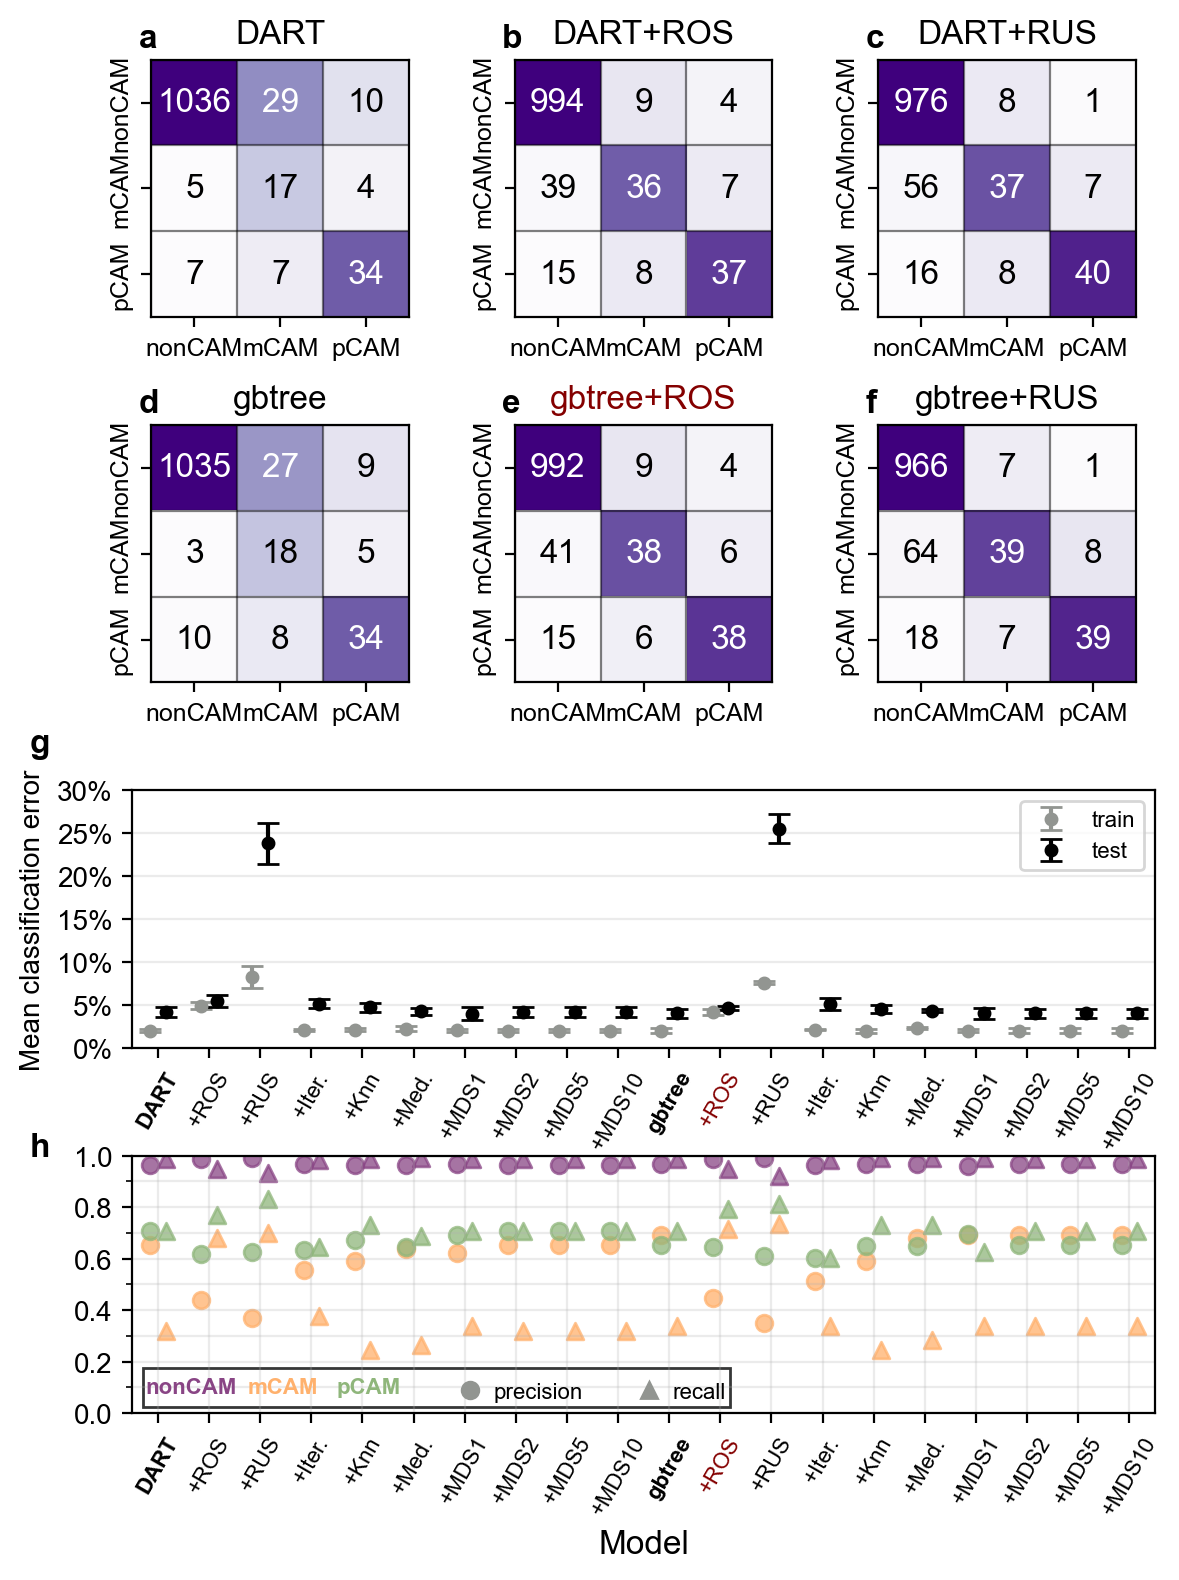

In [69]:
fig,ax = plt.subplot_mosaic(mosaic='''
                                   ABC
                                   DEF
                                   GGG
                                   HHH
                                   ''', figsize=(6,8))

matTitles = ["DART","DART+ROS","DART+RUS",
          "gbtree","gbtree+ROS","gbtree+RUS",]

matCols = ["ypredDartSprobMerr",'ypredROSdart', 'ypredRUSdart', 
        "ypredSprobMerr",'ypredROSxgb', 'ypredRUSxgb',]

for i,c in enumerate(matCols):
    cMat = metrics.confusion_matrix(X_test[c], X_test["label"])
    cMatNorm = metrics.confusion_matrix(X_test[c], X_test["label"],normalize='pred')

    ax[string.ascii_uppercase[i]].imshow(cMatNorm,cmap="Purples")
    ax[string.ascii_uppercase[i]].set_xticks(np.arange(-0.5,2.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_yticks(np.arange(-0.5,2.5,1), minor=True)
    ax[string.ascii_uppercase[i]].set_xticks([0,1,2])
    ax[string.ascii_uppercase[i]].set_yticks([0,1,2])
    ax[string.ascii_uppercase[i]].set_xticklabels(["nonCAM", "mCAM","pCAM",],size=9)
    ax[string.ascii_uppercase[i]].set_yticklabels(["nonCAM", "mCAM","pCAM",],size=9, rotation=90, va="center")
    
    for x in range(len(cMat)):
        for y in range(len(cMat)):
            if cMatNorm[x,y] > 0.5: color="white"
            else: color="black"
            text = ax[string.ascii_uppercase[i]].text(y,x, str(int(cMat[x,y])), ha="center", va="center", color=color, size=12)
    if i in [4]: cTitle="xkcd:dark red"
    else: cTitle="black"
    ax[string.ascii_uppercase[i]].set_title(matTitles[i],size=12, color=cTitle)    
    ax[string.ascii_uppercase[i]].tick_params(which="minor", size=0)
    ax[string.ascii_uppercase[i]].grid(which="minor", color="black", alpha=0.5)
    ax[string.ascii_uppercase[i]].text(s=string.ascii_lowercase[i], x=-0.05, y=1.05, size=12, transform = ax[string.ascii_uppercase[i]].transAxes, weight="bold")
   
# ax['G'].scatter(x=range(len(prmList)), y=mTrainErrorsMeans, marker="o", color="none", edgecolor='black', label="train")
# ax['G'].scatter(x=range(len(prmList)), y=mTestErrorsMeans, marker="x", color="black", edgecolor='black', label="test")
ax['G'].errorbar(x=[i-0.15 for i in range(len(prmList))], y=mTrainErrorsMeans, yerr=mTrainErrorsStds, linestyle='none', marker="o", color="xkcd:grey", label="train", capsize=4, markersize=4)
ax['G'].errorbar(x=[i+0.15 for i in range(len(prmList))], y=mTestErrorsMeans, yerr=mTestErrorsStds, linestyle='none', marker="o", color="black", label="test", capsize=4, markersize=4)
ax['G'].set_yticks(np.arange(0,0.35,0.05))
ax['G'].set_yticklabels(["{:1.0%}".format(i) for i in np.arange(0,0.35,0.05)])
ax['G'].set_ylabel("Mean classification error", size=10)
ax['G'].grid(alpha=0.25, axis="y")
ax['G'].legend(frameon=True, loc="upper right", fontsize=8)
ax['G'].text(s='g', x=-0.1, y=1.15, size=12, transform = ax['G'].transAxes, weight="bold")

phenoAccs = np.array(phenoAccs)
ax['H'].set_yticks(np.arange(0.0,1.1,0.1), minor=True)
ax['H'].set_yticks(np.arange(0.0,1.2,0.2))
# ax['H'].set_yticklabels(["{:1.0}".format(i) for i in np.arange(0.0,1.2,0.2)])
ax['H'].set_ylim(0,1)
# ax['H'].scatter(x=range(len(phenoAccs)), y=phenoAccs[:,0],color=nonCAMcolor, alpha=0.5, label="nonCAM")
# ax['H'].scatter(x=range(len(phenoAccs)), y=phenoAccs[:,1],color=nonpCAMcolor, alpha=0.5, label="mCAM")
# ax['H'].scatter(x=range(len(phenoAccs)), y=phenoAccs[:,2],color=pCAMcolor, alpha=0.5, label="pCAM")
ax['H'].set_xlabel("Model", size=12)
ax['H'].grid(alpha=0.25, axis="both", which="both")
# ax['H'].set_ylabel("True positive rate", size=10, labelpad=0)
# ax['H'].spines['top'].set_visible(False)
# ax['H'].spines['right'].set_visible(False)
for j,pheno in enumerate(["non-CAM","mCAM","pCAM"]):
    ax['H'].scatter(x=[i-0.15 for i in range(len(preds))], y=multiPrecision[j], c=camColorDict[pheno], marker="o", alpha=0.75)
    ax['H'].scatter(x=[i+0.15 for i in range(len(preds))], y=multiRecall[j], c=camColorDict[pheno], alpha=0.75, marker="^")

ax['H'].text(s="nonCAM", x=-0.25, y=0.1, weight='bold', c=camColorDict['non-CAM'], verticalalignment='center',size=8)
ax['H'].text(s="mCAM", x=1.75, y=0.1, weight='bold', c=camColorDict['mCAM'], verticalalignment='center',size=8)
ax['H'].text(s="pCAM", x=3.5, y=0.1, weight='bold', c=camColorDict['pCAM'], verticalalignment='center',size=8)


precisionSquare = Line2D([0], [0], marker='o', color='xkcd:grey', label=r'precision',linestyle="none",)
recallCircle = Line2D([0], [0], marker='^', color='xkcd:grey', label=r'recall',linestyle="none")
# f1Triangle = Line2D([0], [0], marker='x', color='xkcd:grey',  label=r'f1-score',linestyle="none")
ax['H'].legend(handles=[precisionSquare, recallCircle], frameon=False, loc=[0.3,0.01], fontsize=8, ncol=3, handletextpad=0.05)

rect = Rectangle(xy=[-0.3, 0.025], height=0.15, width=11.5, edgecolor="xkcd:dark grey", facecolor='None', )
ax['H'].add_patch(rect)

for l in ['G','H']:
    ax[l].set_xticks(range(len(prmList)))
    ax[l].set_xlim(-0.5,len(prmList)-0.5)
    ax[l].set_xticklabels(["DART","+ROS","+RUS","+Iter.","+Knn","+Med.","+MDS1","+MDS2","+MDS5","+MDS10",
                             "gbtree","+ROS","+RUS","+Iter.","+Knn","+Med.","+MDS1","+MDS2","+MDS5","+MDS10",], size=8, rotation=60)
    for i,t in enumerate(ax[l].get_xticklabels()):
        if i%10 == 0:
            t.set_weight("bold")
        if i==11: t.set_color("xkcd:dark red")

# purpleDot = Line2D([0], [0], marker='o', color=nonCAMcolor, label=r'nonCAM',linestyle="none")
# yellowDot = Line2D([0], [0], marker='o', color=nonpCAMcolor, label=r'mCAM',linestyle="none")
# greenDot = Line2D([0], [0], marker='o', color=pCAMcolor,  label=r'pCAM',linestyle="none")
# ax['H'].legend(handles=[purpleDot,yellowDot,greenDot], frameon=True, loc="lower right", fontsize=8, ncol=3)
ax['H'].text(s='h', x=-0.1, y=1.0, size=12, transform = ax['H'].transAxes, weight="bold")

plt.tight_layout(h_pad=-0.75)
# plt.savefig("../Figures/MulticlassAccuracyConfMats.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

### Misclassified taxa

In [70]:
X_test[X_test["ypredROSxgb"]!=X_test["label"]][["MajorLineage", "Taxon", "Pathway", "CAMpheno", "ypredROSxgb"]].replace({0:"nonCAM", 
                                                                                                                   1:"mCAM", 
                                                                                                                   2:"pCAM"},).sort_values(["CAMpheno",
                                                                                                                                            "ypredROSxgb",
                                                                                                                                           "MajorLineage",
                                                                                                                                            "Taxon"]).rename({"MajorLineage":"Major lineage",
                                                                                                                                                                 "CAMpheno":"True label",
                                                                                                                                                                 "ypredROSxgb":"Predicted label"},axis=1).to_csv("../Results/ROS-XGB-misclassified.csv",index=False)

In [71]:
X_test[X_test["ypredROSdart"]!=X_test["label"]][["MajorLineage", "Taxon", "Pathway", "CAMpheno", "ypredROSdart"]].replace({0:"nonCAM", 
                                                                                                                   1:"mCAM", 
                                                                                                                   2:"pCAM"},).sort_values(["CAMpheno",
                                                                                                                                            "ypredROSdart",
                                                                                                                                           "MajorLineage",
                                                                                                                                            "Taxon"]).rename({"MajorLineage":"Major lineage",
                                                                                                                                                                 "CAMpheno":"True label",
                                                                                                                                                                 "ypredROSdart":"Predicted label"},axis=1).to_csv("../Results/ROS-DART-misclassified.csv",index=False)

## Feature scores for alterative models

In [72]:
bstList = [bstDartSprobMerr,bstROSdart,bstRUSdart,bstIterSmaxMerrDart,bstKnnSmaxMerrDart,bstMedSmaxMerrDart,bstMD1dart,bstMD2dart,bstMD5dart,bstMD10dart,
       bstSprobMerr,bstROSxgb,bstRUSxgb,bstIterSmaxMerrXgb,bstKnnSmaxMerrXgb,bstMedSmaxMerrXgb,bstMD1xgb,bstMD2xgb,bstMD5xgb,bstMD10xgb,]

keys = ['LTmean (um)','MAmean (um^2)','LDMCmean (g/g)','dSLAmean (mm^2/mg)','IASmean (%)']
fScores = []

for b in bstList:
    fScores.append([b.get_fscore()[k]/sum(b.get_fscore().values()) for k in keys])

fScores = pd.DataFrame(fScores, columns=keys)

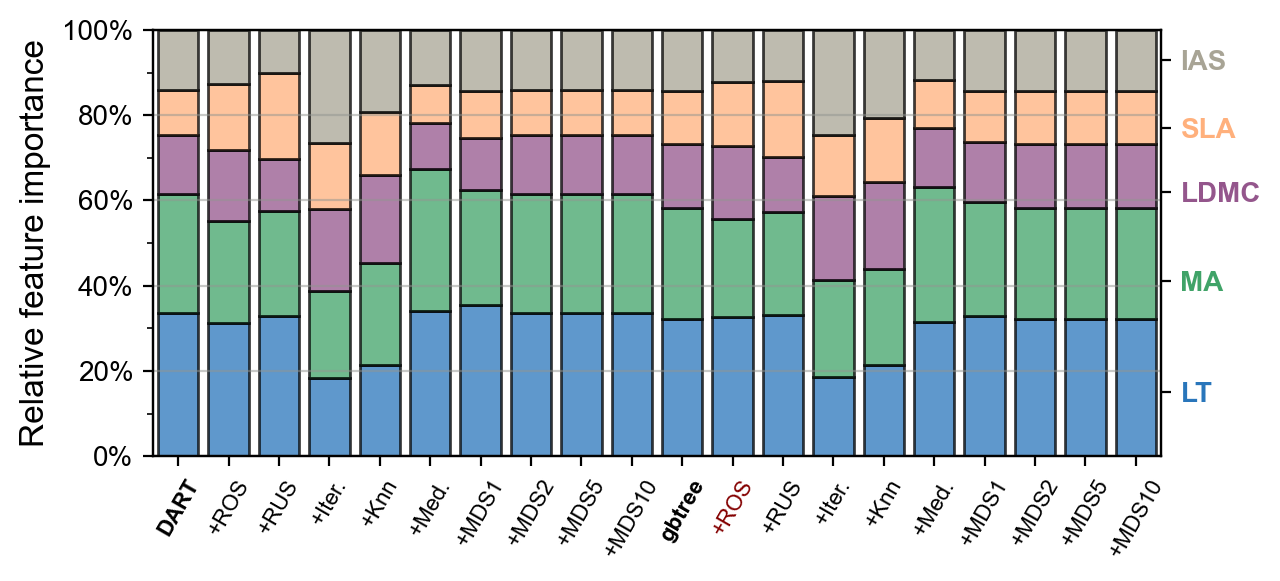

In [73]:
fig, ax = plt.subplots(figsize=(6.5,3))

barColors = ["xkcd:bluish", "xkcd:greenish","xkcd:purplish","xkcd:peach","xkcd:greyish"]
for i,k in enumerate(keys):
    if i==0:
        ax.bar(x=range(len(fScores)), height=fScores[k], alpha=0.75, color=barColors[i], edgecolor="black")
    else:
        ax.bar(x=range(len(fScores)), height=fScores[k], bottom=fScores[keys[:i]].sum(axis=1), alpha=0.75, color=barColors[i], edgecolor="black")
  
ax.set_xticks(range(20))
ax.set_xticklabels(["DART","+ROS","+RUS","+Iter.","+Knn","+Med.","+MDS1","+MDS2","+MDS5","+MDS10",
                             "gbtree","+ROS","+RUS","+Iter.","+Knn","+Med.","+MDS1","+MDS2","+MDS5","+MDS10",], size=8, rotation=60)
ax.set_xlim(-0.5,19.5)
ax.set_yticks(np.arange(0,1.2,0.2))
ax.set_yticks(np.arange(0,1.1,0.1), minor=True)
ax.set_yticklabels(["{:1.0%}".format(t) for t in ax.get_yticks()])
ax.set_ylim(0,1)
ax.set_ylabel("Relative feature importance", size=12)
ax.grid(color="xkcd:grey", alpha=0.5, axis="y")
for i,t in enumerate(ax.get_xticklabels()):
    if i%10 == 0:
        t.set_weight("bold")
    if i == 11: t.set_color("xkcd:dark red")

ax2 = ax.twinx()
ax2.set_yticks([0.15,0.41,0.62,0.77,0.93])
ax2.set_yticklabels(["LT", "MA", "LDMC", "SLA", "IAS"], weight="bold")
for ticklabel, tickcolor in zip(ax2.get_yticklabels(), barColors):
    ticklabel.set_color(tickcolor)
    
plt.tight_layout()
# plt.savefig("../Figures/MulticlassFscores.pdf", format="pdf", dpi=150, transparent=False, bbox_inches="tight")

In [74]:
fScores["Model"] = ["DART","DART+ROS","DART+RUS","DART+Iter.","DART+Knn","DART+Med.","DART+MDS1","DART+MDS2","DART+MDS5","DART+MDS10",
                    "gbtree","gbtree+ROS","gbtree+RUS","gbtree+Iter.","gbtree+Knn","gbtree+Med.","gbtree+MDS1","gbtree+MDS2","gbtree+MDS5","gbtree+MDS10",]
fScores[["Model"]+keys].to_csv("../Results/MulticlassModelFscores.csv",index=False)